In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import re
from scipy import sparse

# For machine learning
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,classification_report,confusion_matrix
from sklearn.svm import SVC

# For nlp
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline, FeatureUnion
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import pickle
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import warnings
warnings.simplefilter('ignore')

In [3]:
#!pip install gensim

In [4]:
file_name = "./FA2013-2019.xlsx"

xls = pd.ExcelFile(file_name)
sheet_to_df_map = {}
for sheet_name in xls.sheet_names:
    print(sheet_name)
    sheet_to_df_map[sheet_name] = xls.parse(sheet_name)

パ全


# 1. EDA

In [5]:
dfs = pd.read_excel(file_name, sheet_name=None)

In [6]:
df_org = dfs['パ全']
print(df_org.shape) #(25768, 72)

# Drop null items
df_org = df_org[df_org.notnull()]
print(df_org.shape) #(25768, 72)

(25768, 72)
(25768, 72)


In [7]:
df_org.head()

,ID,パーク全体FA,年度,来園月,来園日,同行形態,TDL1年以内来園回数,再来園意向,性別,年齢,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N
0,A1,カヌーに乗れて良かったです,2013,4,1,3,4,2.0,2,47.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,A3,混んでた割には、アトラクションが楽しめて良かったです。,2013,4,1,3,1,2.0,2,40.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,A6,やはり待ち時間が長い（春休みなのでしょうがないか） アトラクションがマンネリ化してきた。,2013,4,2,3,2,2.0,1,52.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,A7,久しぶりにいったランド。春休みということでの混雑 そして、雨 残念でしたが良い思い出ができ...,2013,4,2,3,1,2.0,2,37.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,A9,悪天候だった為、アトラクションで待つときビチョビチョになり寒かった。,2013,4,3,6,1,1.0,2,41.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Dataset overview

In [8]:
# remove irrelevant columns
df_org = df_org.drop(columns=['年度', '来園月','来園日','同行形態','TDL1年以内来園回数','再来園意向','性別','年齢'])

In [9]:
file_name = "./FA2013-2019.xlsx"

def load_data(file_name):

    # read sheet from excel file
    dfs = pd.read_excel(file_name, sheet_name=None)
    df_org = dfs['パ全']

    # drop null items
    df_org = df_org[df_org.notnull()]

    # remove irrelevant columns
    df_org = df_org.drop(columns=['年度', '来園月','来園日','同行形態','TDL1年以内来園回数','再来園意向','性別','年齢'])

    print('DataFrame dim:', df_org.shape, '\n')
    X = df_org['パーク全体FA']
    y = df_org.iloc[:,2:]
    return X, y

X,y = load_data(file_name)

DataFrame dim: (25768, 64) 



In [10]:
print(df_org.info())
print(df_org.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25768 entries, 0 to 25767
Data columns (total 64 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   ID                        25768 non-null  object
 1   パーク全体FA                   25768 non-null  object
 2   パーク全般P                    25768 non-null  int64 
 3   園内全体の外観・装飾P               25768 non-null  int64 
 4   園内全体の混雑状況P                25768 non-null  int64 
 5   清潔感P                      25768 non-null  int64 
 6   スペシャルイベント（装飾）P            25768 non-null  int64 
 7   スペシャルイベント（その他）P           25768 non-null  int64 
 8   園内環境P                     25768 non-null  int64 
 9   価格P                       25768 non-null  int64 
 10  その他（パーク全体）P               25768 non-null  int64 
 11  【アトラクション】質（面白さ）P          25768 non-null  int64 
 12  【アトラクション】待ち時間/混雑状況P       25768 non-null  int64 
 13  【アトラクション】休止・工事（リハブ・シス調）P  25768 non-null  int64 
 14  【アトラクション】休止（天候要因）P    

In [11]:
print(df_org.ID.is_unique)
print('Number of rows with skips in original data: {}'.format(df_org['パーク全体FA'].isnull().sum()))

False
Number of rows with skips in original data: 0


## Melt labels

In [13]:
df_labels = pd.DataFrame(df_org,columns=df_org.columns[2:])
df_m = pd.melt(df_labels)
df_m

,variable,value
0,パーク全般P,0
1,パーク全般P,0
2,パーク全般P,0
3,パーク全般P,1
4,パーク全般P,0
...,...,...
1597611,【その他サービス施設】その他N,0
1597612,【その他サービス施設】その他N,0
1597613,【その他サービス施設】その他N,0
1597614,【その他サービス施設】その他N,0


In [14]:
df_m.loc[df_m['value']!=0]

,variable,value
3,パーク全般P,1
11,パーク全般P,1
16,パーク全般P,1
18,パーク全般P,1
19,パーク全般P,1
...,...,...
1597527,【その他サービス施設】その他N,1
1597557,【その他サービス施設】その他N,1
1597565,【その他サービス施設】その他N,1
1597595,【その他サービス施設】その他N,1


## Labels Analysis

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12497 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12540 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12463 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 20840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 33324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22290 missing from current font.
  font.set_

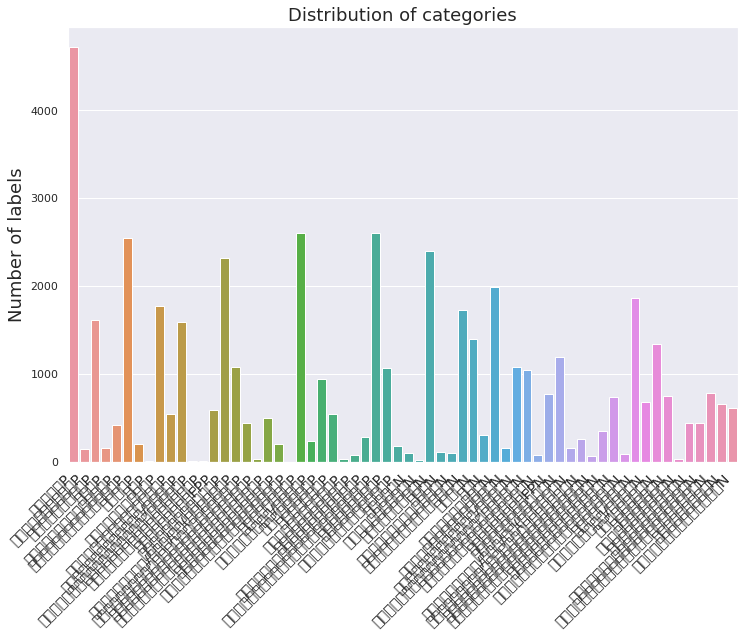

In [17]:
import seaborn as sns
sns.set()
plt.figure(figsize =(12,8))
_=sns.countplot(data=df_m.loc[df_m['value']!=0], x='variable')
_.set_xticklabels(_.get_xticklabels(),rotation=45, horizontalalignment='right', fontweight='light', fontsize='large')
plt.title('Distribution of categories', fontsize=18)
plt.xlabel('')
plt.ylabel('Number of labels', fontsize=18)
plt.show()

In [18]:
print(df_labels.sum(axis=0))
pd.DataFrame(df_labels.sum(axis=0)).transpose()

パーク全般P                      4713
園内全体の外観・装飾P                  142
園内全体の混雑状況P                  1609
清潔感P                         153
スペシャルイベント（装飾）P               417
                            ... 
【レストルーム】その他N                 445
【キャスト】対応能力（迅速さ・正確さ）N         439
【キャスト】態度・印象（笑顔・礼儀・話し方等）N     785
【キャスト】その他N                   654
【その他サービス施設】その他N              615
Length: 62, dtype: int64


,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N
0,4713,142,1609,153,417,2541,197,11,1770,546,1588,7,8,588,2316,1075,436,32,499,199,1,2596,239,938,539,29,75,281,2607,1070,176,98,24,2393,108,96,1730,1397,298,1990,153,1071,1040,79,773,1190,155,259,69,347,737,86,1862,674,1343,749,30,445,439,785,654,615


## Comments Analysis

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


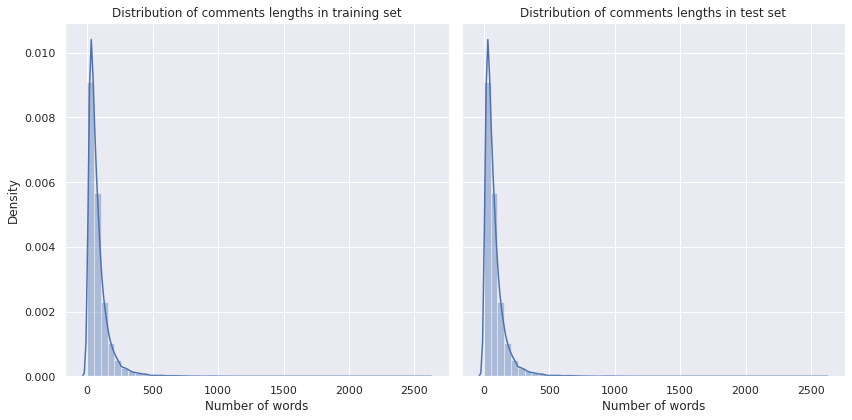

In [19]:
f, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
sns.distplot(df_org['パーク全体FA'].apply(lambda x: len(str(x))), hist=True, ax=axes[0])
axes[0].set_title('Distribution of comments lengths in training set')
axes[0].set_xlabel('Number of words')
sns.distplot(df_org['パーク全体FA'].apply(lambda x: len(str(x))), hist=True, ax=axes[1])
axes[1].set_title('Distribution of comments lengths in test set')
axes[1].set_xlabel('Number of words')
plt.tight_layout()
plt.show()

### Summaries:
1. The distribution of the number of words in the query training and test sample are quite similar. 
2. The majority of queries contain less than 400 words.
3. Distributions have peaks in the range of 2 and 10 words. 
4. There are also long "tails" up to 2500 words long.

81.63373176032287 91.96884288857746 2592


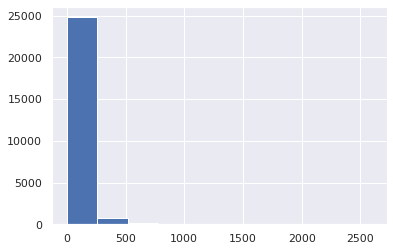

In [20]:
# The length of the comments
lens = df_org['パーク全体FA'].str.len()
print(lens.mean(), lens.std(), lens.max())
lens.hist();

In [21]:
df_org[df_org['パーク全体FA'].str.len()==1]

,ID,パーク全体FA,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N
14280,A04670,あ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23143,13174,か,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
lens

0         13
1         27
2         44
3        118
4         34
        ... 
25763     86
25764     32
25765    358
25766     75
25767    351
Name: パーク全体FA, Length: 25768, dtype: int64

## Most frequently used phrases

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 29305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12394 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12375 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27005 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12363 missing from current font.
  font.set_

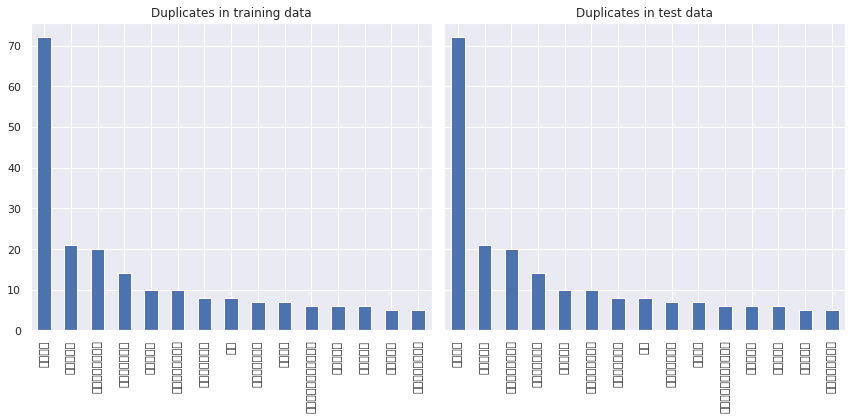

In [24]:
f, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
df_org.groupby('パーク全体FA')['パーク全体FA'].count().sort_values(ascending=False)[:15].plot(kind='bar', ax=axes[0])
axes[0].set_title('Duplicates in training data')
axes[0].set_xlabel('')
df_org.groupby('パーク全体FA')['パーク全体FA'].count().sort_values(ascending=False)[:15].plot(kind='bar', ax=axes[1])
axes[1].set_title('Duplicates in test data')
axes[1].set_xlabel('')
plt.tight_layout()
plt.show()


In [25]:
df_org.groupby('パーク全体FA')['パーク全体FA'].count().sort_values(ascending=False)[:15]

パーク全体FA
特になし           72
楽しかった          21
特にありません。       20
特にありません        14
特になし。          10
楽しかったです。       10
楽しかったから         8
なし              8
楽しかったです         7
特に無し            7
とても楽しかったです。     6
空いていた           6
とくになし           6
混んでいた           5
楽しかったです！        5
Name: パーク全体FA, dtype: int64

## Analysis on Each Comment

In [28]:
dic_labels = {i:df_labels.columns.get_loc(i) for i in df_labels.columns}
dic_labels

{'【その他サービス施設】その他N': 61,
 '【その他サービス施設】その他P': 30,
 '【アトラクション】FPN': 44,
 '【アトラクション】FPP': 13,
 '【アトラクション】その他N': 45,
 '【アトラクション】その他P': 14,
 '【アトラクション】休止・工事（リハブ・シス調）N': 42,
 '【アトラクション】休止・工事（リハブ・シス調）P': 11,
 '【アトラクション】休止（天候要因）N': 43,
 '【アトラクション】休止（天候要因）P': 12,
 '【アトラクション】待ち時間/混雑状況N': 41,
 '【アトラクション】待ち時間/混雑状況P': 10,
 '【アトラクション】質（面白さ）N': 40,
 '【アトラクション】質（面白さ）P': 9,
 '【エンタ】その他N': 52,
 '【エンタ】その他P': 21,
 '【エンタ】キャラクターグリーティング（その他）N': 49,
 '【エンタ】キャラクターグリーティング（その他）P': 18,
 '【エンタ】キャラクターグリーティング（出会い）N': 47,
 '【エンタ】キャラクターグリーティング（出会い）P': 16,
 '【エンタ】キャラクターグリーティング（混雑）N': 48,
 '【エンタ】キャラクターグリーティング（混雑）P': 17,
 '【エンタ】パレード/ショー/花火(質・面白さ）N': 46,
 '【エンタ】パレード/ショー/花火(質・面白さ）P': 15,
 '【エンタ】休止・中止（リハブ・シス調）N': 51,
 '【エンタ】休止・中止（リハブ・シス調）P': 20,
 '【エンタ】休止・中止（悪天候）N': 50,
 '【エンタ】休止・中止（悪天候）P': 19,
 '【キャスト】その他N': 60,
 '【キャスト】その他P': 29,
 '【キャスト】対応能力（迅速さ・正確さ）N': 58,
 '【キャスト】対応能力（迅速さ・正確さ）P': 27,
 '【キャスト】態度・印象（笑顔・礼儀・話し方等）N': 59,
 '【キャスト】態度・印象（笑顔・礼儀・話し方等）P': 28,
 '【フード】その他N': 54,
 '【フード】その他P': 23,
 '【フード】待ち時間/混雑状況N': 53,
 '【フード】待ち時間/混

In [29]:
df_ctx_lbl.head()

,パーク全体FA,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N
0,カヌーに乗れて良かったです,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,混んでた割には、アトラクションが楽しめて良かったです。,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,やはり待ち時間が長い（春休みなのでしょうがないか） アトラクションがマンネリ化してきた。,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,久しぶりにいったランド。春休みということでの混雑 そして、雨 残念でしたが良い思い出ができ...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,悪天候だった為、アトラクションで待つときビチョビチョになり寒かった。,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
df_labels["targets"] = df_labels.apply(lambda x: list(x[x>0].index), axis=1)

In [36]:
df_ctx_lbl_tgt = pd.concat([df_ctx_lbl,df_labels["targets"]], axis=1)
assert df_org.shape[0] == df_ctx_lbl_tgt.shape[0]

In [37]:
print("shapes:",df_ctx_lbl_tgt.shape)
df_ctx_lbl_tgt.head(1)

shapes: (25768, 64)


,パーク全体FA,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N,targets
0,カヌーに乗れて良かったです,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,[【アトラクション】その他P]


### Notes:
1. 790 items with no label.
2. 1 item with invalid label

In [39]:
# remove void label items
df_ctx_lbl_tgt_null = df_ctx_lbl_tgt[~(df_ctx_lbl_tgt.targets.str.len() > 0)]
df_ctx_lbl_tgt_clean = df_ctx_lbl_tgt[(df_ctx_lbl_tgt.targets.str.len() > 0)]

In [40]:
print(df_ctx_lbl_tgt_clean.shape)
df_new = df_ctx_lbl_tgt_clean.drop('targets',axis=1)
print(df_new.shape)

(24978, 64)
(24978, 63)


In [41]:
df_new.head(1)

,パーク全体FA,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N
0,カヌーに乗れて良かったです,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Remove confusing labellings

In [42]:
df_new_clean = df_new[~((df_new['【フード】その他P']==1) & (df_new['【フード】その他N']==1))]

In [43]:
assert (df_new.shape[0] - df_new_clean.shape[0]) == df_new[(df_new['【フード】その他P']==1) & (df_new['【フード】その他N']==1)].shape[0]

In [44]:
print(df_new[(df_new['パーク全般P']==1) & (df_new['パーク全般N']==1)].shape)
print(df_new[(df_new['園内全体の外観・装飾P']==1) & (df_new['園内全体の外観・装飾N']==1)].shape)
print(df_new[(df_new['園内全体の混雑状況P']==1) & (df_new['園内全体の混雑状況N']==1)].shape)
print(df_new[(df_new['清潔感P']==1) & (df_new['清潔感N']==1)].shape)
print(df_new[(df_new['スペシャルイベント（装飾）P']==1) & (df_new['スペシャルイベント（装飾）N']==1)].shape)
print(df_new[(df_new['スペシャルイベント（その他）P']==1) & (df_new['スペシャルイベント（その他）N']==1)].shape)
print(df_new[(df_new['園内環境P']==1) & (df_new['園内環境N']==1)].shape)
print(df_new[(df_new['価格P']==1) & (df_new['価格N']==1)].shape)
print(df_new[(df_new['その他（パーク全体）P']==1) & (df_new['その他（パーク全体）N']==1)].shape)
print(df_new[(df_new['【アトラクション】質（面白さ）P']==1) & (df_new['【アトラクション】質（面白さ）N']==1)].shape)
print(df_new[(df_new['【アトラクション】待ち時間/混雑状況P']==1) & (df_new['【アトラクション】待ち時間/混雑状況N']==1)].shape)
print(df_new[(df_new['【アトラクション】休止・工事（リハブ・シス調）P']==1) & (df_new['【アトラクション】休止・工事（リハブ・シス調）N']==1)].shape)
print(df_new[(df_new['【アトラクション】休止（天候要因）P']==1) & (df_new['【アトラクション】休止（天候要因）N']==1)].shape)
print(df_new[(df_new['【アトラクション】FPP']==1) & (df_new['【アトラクション】FPN']==1)].shape)
print(df_new[(df_new['【アトラクション】その他P']==1) & (df_new['【アトラクション】その他N']==1)].shape)
print(df_new[(df_new['【エンタ】パレード/ショー/花火(質・面白さ）P']==1) & (df_new['【エンタ】パレード/ショー/花火(質・面白さ）N']==1)].shape)
print(df_new[(df_new['【エンタ】キャラクターグリーティング（出会い）P']==1) & (df_new['【エンタ】キャラクターグリーティング（出会い）N']==1)].shape)
print(df_new[(df_new['【エンタ】キャラクターグリーティング（混雑）P']==1) & (df_new['【エンタ】キャラクターグリーティング（混雑）N']==1)].shape)
print(df_new[(df_new['【エンタ】キャラクターグリーティング（その他）P']==1) & (df_new['【エンタ】キャラクターグリーティング（その他）N']==1)].shape)
print(df_new[(df_new['【エンタ】休止・中止（悪天候）P']==1) & (df_new['【エンタ】休止・中止（悪天候）N']==1)].shape)
print(df_new[(df_new['【エンタ】休止・中止（リハブ・シス調）P']==1) & (df_new['【エンタ】休止・中止（リハブ・シス調）N']==1)].shape)
print(df_new[(df_new['【エンタ】その他P']==1) & (df_new['【エンタ】その他N']==1)].shape)
print(df_new[(df_new['【フード】待ち時間/混雑状況P']==1) & (df_new['【フード】待ち時間/混雑状況N']==1)].shape)
print(df_new[(df_new['【フード】その他P']==1) & (df_new['【フード】その他N']==1)].shape)
print(df_new[(df_new['【商品】その他P']==1) & (df_new['【商品】その他N']==1)].shape)
print(df_new[(df_new['【レストルーム】清潔さP']==1) & (df_new['【レストルーム】清潔さN']==1)].shape)
print(df_new[(df_new['【レストルーム】その他P']==1) & (df_new['【レストルーム】その他N']==1)].shape)
print(df_new[(df_new['【キャスト】対応能力（迅速さ・正確さ）P']==1) & (df_new['【キャスト】対応能力（迅速さ・正確さ）N']==1)].shape)
print(df_new[(df_new['【キャスト】態度・印象（笑顔・礼儀・話し方等）P']==1) & (df_new['【キャスト】態度・印象（笑顔・礼儀・話し方等）N']==1)].shape)
print(df_new[(df_new['【キャスト】その他P']==1) & (df_new['【キャスト】その他N']==1)].shape)
print(df_new[(df_new['【その他サービス施設】その他P']==1) & (df_new['【その他サービス施設】その他N']==1)].shape)

(12, 63)
(3, 63)
(15, 63)
(1, 63)
(15, 63)
(414, 63)
(25, 63)
(0, 63)
(166, 63)
(25, 63)
(22, 63)
(1, 63)
(0, 63)
(31, 63)
(90, 63)
(32, 63)
(11, 63)
(0, 63)
(33, 63)
(45, 63)
(0, 63)
(238, 63)
(6, 63)
(88, 63)
(50, 63)
(0, 63)
(9, 63)
(13, 63)
(133, 63)
(41, 63)
(29, 63)


In [45]:
#df_new = df_new[~((df_new['【フード】その他P']==1) & (df_new['【フード】その他N']==1))]
df_new = df_new[~((df_new['パーク全般P']==1) & (df_new['パーク全般N']==1))]
df_new = df_new[~((df_new['園内全体の外観・装飾P']==1) & (df_new['園内全体の外観・装飾N']==1))]
df_new = df_new[~((df_new['園内全体の混雑状況P']==1) & (df_new['園内全体の混雑状況N']==1))]
df_new = df_new[~((df_new['清潔感P']==1) & (df_new['清潔感N']==1))]
df_new = df_new[~((df_new['スペシャルイベント（装飾）P']==1) & (df_new['スペシャルイベント（装飾）N']==1))]
df_new = df_new[~((df_new['スペシャルイベント（その他）P']==1) & (df_new['スペシャルイベント（その他）N']==1))]
df_new = df_new[~((df_new['園内環境P']==1) & (df_new['園内環境N']==1))]
df_new = df_new[~((df_new['価格P']==1) & (df_new['価格N']==1))]
df_new = df_new[~((df_new['その他（パーク全体）P']==1) & (df_new['その他（パーク全体）N']==1))]
df_new = df_new[~((df_new['【アトラクション】質（面白さ）P']==1) & (df_new['【アトラクション】質（面白さ）N']==1))]
df_new = df_new[~((df_new['【アトラクション】待ち時間/混雑状況P']==1) & (df_new['【アトラクション】待ち時間/混雑状況N']==1))]
df_new = df_new[~((df_new['【アトラクション】休止・工事（リハブ・シス調）P']==1) & (df_new['【アトラクション】休止・工事（リハブ・シス調）N']==1))]
df_new = df_new[~((df_new['【アトラクション】休止（天候要因）P']==1) & (df_new['【アトラクション】休止（天候要因）N']==1))]
df_new = df_new[~((df_new['【アトラクション】FPP']==1) & (df_new['【アトラクション】FPN']==1))]
df_new = df_new[~((df_new['【アトラクション】その他P']==1) & (df_new['【アトラクション】その他N']==1))]
df_new = df_new[~((df_new['【エンタ】パレード/ショー/花火(質・面白さ）P']==1) & (df_new['【エンタ】パレード/ショー/花火(質・面白さ）N']==1))]
df_new = df_new[~((df_new['【エンタ】キャラクターグリーティング（出会い）P']==1) & (df_new['【エンタ】キャラクターグリーティング（出会い）N']==1))]
df_new = df_new[~((df_new['【エンタ】キャラクターグリーティング（混雑）P']==1) & (df_new['【エンタ】キャラクターグリーティング（混雑）N']==1))]
df_new = df_new[~((df_new['【エンタ】キャラクターグリーティング（その他）P']==1) & (df_new['【エンタ】キャラクターグリーティング（その他）N']==1))]
df_new = df_new[~((df_new['【エンタ】休止・中止（悪天候）P']==1) & (df_new['【エンタ】休止・中止（悪天候）N']==1))]
df_new = df_new[~((df_new['【エンタ】休止・中止（リハブ・シス調）P']==1) & (df_new['【エンタ】休止・中止（リハブ・シス調）N']==1))]
df_new = df_new[~((df_new['【エンタ】その他P']==1) & (df_new['【エンタ】その他N']==1))]
df_new = df_new[~((df_new['【フード】待ち時間/混雑状況P']==1) & (df_new['【フード】待ち時間/混雑状況N']==1))]
df_new = df_new[~((df_new['【フード】その他P']==1) & (df_new['【フード】その他N']==1))]
df_new = df_new[~((df_new['【商品】その他P']==1) & (df_new['【商品】その他N']==1))]
df_new = df_new[~((df_new['【レストルーム】清潔さP']==1) & (df_new['【レストルーム】清潔さN']==1))]
df_new = df_new[~((df_new['【レストルーム】その他P']==1) & (df_new['【レストルーム】その他N']==1))]
df_new = df_new[~((df_new['【キャスト】対応能力（迅速さ・正確さ）P']==1) & (df_new['【キャスト】対応能力（迅速さ・正確さ）N']==1))]
df_new = df_new[~((df_new['【キャスト】態度・印象（笑顔・礼儀・話し方等）P']==1) & (df_new['【キャスト】態度・印象（笑顔・礼儀・話し方等）N']==1))]
df_new = df_new[~((df_new['【キャスト】その他P']==1) & (df_new['【キャスト】その他N']==1))]
df_new = df_new[~((df_new['【その他サービス施設】その他P']==1) & (df_new['【その他サービス施設】その他N']==1))]

In [46]:
print(df_new[(df_new['パーク全般P']==1) & (df_new['パーク全般N']==1)].shape)
print(df_new[(df_new['園内全体の外観・装飾P']==1) & (df_new['園内全体の外観・装飾N']==1)].shape)
print(df_new[(df_new['園内全体の混雑状況P']==1) & (df_new['園内全体の混雑状況N']==1)].shape)
print(df_new[(df_new['清潔感P']==1) & (df_new['清潔感N']==1)].shape)
print(df_new[(df_new['スペシャルイベント（装飾）P']==1) & (df_new['スペシャルイベント（装飾）N']==1)].shape)
print(df_new[(df_new['スペシャルイベント（その他）P']==1) & (df_new['スペシャルイベント（その他）N']==1)].shape)
print(df_new[(df_new['園内環境P']==1) & (df_new['園内環境N']==1)].shape)
print(df_new[(df_new['価格P']==1) & (df_new['価格N']==1)].shape)
print(df_new[(df_new['その他（パーク全体）P']==1) & (df_new['その他（パーク全体）N']==1)].shape)
print(df_new[(df_new['【アトラクション】質（面白さ）P']==1) & (df_new['【アトラクション】質（面白さ）N']==1)].shape)
print(df_new[(df_new['【アトラクション】待ち時間/混雑状況P']==1) & (df_new['【アトラクション】待ち時間/混雑状況N']==1)].shape)
print(df_new[(df_new['【アトラクション】休止・工事（リハブ・シス調）P']==1) & (df_new['【アトラクション】休止・工事（リハブ・シス調）N']==1)].shape)
print(df_new[(df_new['【アトラクション】休止（天候要因）P']==1) & (df_new['【アトラクション】休止（天候要因）N']==1)].shape)
print(df_new[(df_new['【アトラクション】FPP']==1) & (df_new['【アトラクション】FPN']==1)].shape)
print(df_new[(df_new['【アトラクション】その他P']==1) & (df_new['【アトラクション】その他N']==1)].shape)
print(df_new[(df_new['【エンタ】パレード/ショー/花火(質・面白さ）P']==1) & (df_new['【エンタ】パレード/ショー/花火(質・面白さ）N']==1)].shape)
print(df_new[(df_new['【エンタ】キャラクターグリーティング（出会い）P']==1) & (df_new['【エンタ】キャラクターグリーティング（出会い）N']==1)].shape)
print(df_new[(df_new['【エンタ】キャラクターグリーティング（混雑）P']==1) & (df_new['【エンタ】キャラクターグリーティング（混雑）N']==1)].shape)
print(df_new[(df_new['【エンタ】キャラクターグリーティング（その他）P']==1) & (df_new['【エンタ】キャラクターグリーティング（その他）N']==1)].shape)
print(df_new[(df_new['【エンタ】休止・中止（悪天候）P']==1) & (df_new['【エンタ】休止・中止（悪天候）N']==1)].shape)
print(df_new[(df_new['【エンタ】休止・中止（リハブ・シス調）P']==1) & (df_new['【エンタ】休止・中止（リハブ・シス調）N']==1)].shape)
print(df_new[(df_new['【エンタ】その他P']==1) & (df_new['【エンタ】その他N']==1)].shape)
print(df_new[(df_new['【フード】待ち時間/混雑状況P']==1) & (df_new['【フード】待ち時間/混雑状況N']==1)].shape)
print(df_new[(df_new['【フード】その他P']==1) & (df_new['【フード】その他N']==1)].shape)
print(df_new[(df_new['【商品】その他P']==1) & (df_new['【商品】その他N']==1)].shape)
print(df_new[(df_new['【レストルーム】清潔さP']==1) & (df_new['【レストルーム】清潔さN']==1)].shape)
print(df_new[(df_new['【レストルーム】その他P']==1) & (df_new['【レストルーム】その他N']==1)].shape)
print(df_new[(df_new['【キャスト】対応能力（迅速さ・正確さ）P']==1) & (df_new['【キャスト】対応能力（迅速さ・正確さ）N']==1)].shape)
print(df_new[(df_new['【キャスト】態度・印象（笑顔・礼儀・話し方等）P']==1) & (df_new['【キャスト】態度・印象（笑顔・礼儀・話し方等）N']==1)].shape)
print(df_new[(df_new['【キャスト】その他P']==1) & (df_new['【キャスト】その他N']==1)].shape)
print(df_new[(df_new['【その他サービス施設】その他P']==1) & (df_new['【その他サービス施設】その他N']==1)].shape)

(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)
(0, 63)


In [47]:
print(df_new.shape)
df_new.head(1)

(23474, 63)


,パーク全体FA,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N
0,カヌーに乗れて良かったです,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
from sklearn.model_selection import train_test_split 
def make_split(df_new, test_size = 0.2):
    '''Returns X_train, X_test, y_train, y_test'''    
    df_train, df_test = train_test_split(df_new, test_size = 0.2, random_state = 2020)   

    return df_train, df_test

In [49]:
df_train, df_test = make_split(df_new)
print(df_train.shape, df_test.shape) #old: (19982, 63) (4996, 63); clean: (18779, 63) (4695, 63)

(18779, 63) (4695, 63)


In [50]:
df_train.head(1)

,パーク全体FA,パーク全般P,園内全体の外観・装飾P,園内全体の混雑状況P,清潔感P,スペシャルイベント（装飾）P,スペシャルイベント（その他）P,園内環境P,価格P,その他（パーク全体）P,【アトラクション】質（面白さ）P,【アトラクション】待ち時間/混雑状況P,【アトラクション】休止・工事（リハブ・シス調）P,【アトラクション】休止（天候要因）P,【アトラクション】FPP,【アトラクション】その他P,【エンタ】パレード/ショー/花火(質・面白さ）P,【エンタ】キャラクターグリーティング（出会い）P,【エンタ】キャラクターグリーティング（混雑）P,【エンタ】キャラクターグリーティング（その他）P,【エンタ】休止・中止（悪天候）P,【エンタ】休止・中止（リハブ・シス調）P,【エンタ】その他P,【フード】待ち時間/混雑状況P,【フード】その他P,【商品】その他P,【レストルーム】清潔さP,【レストルーム】その他P,【キャスト】対応能力（迅速さ・正確さ）P,【キャスト】態度・印象（笑顔・礼儀・話し方等）P,【キャスト】その他P,【その他サービス施設】その他P,パーク全般N,園内全体の外観・装飾N,園内全体の混雑状況N,清潔感N,スペシャルイベント（装飾）N,スペシャルイベント（その他）N,園内環境N,価格N,その他（パーク全体）N,【アトラクション】質（面白さ）N,【アトラクション】待ち時間/混雑状況N,【アトラクション】休止・工事（リハブ・シス調）N,【アトラクション】休止（天候要因）N,【アトラクション】FPN,【アトラクション】その他N,【エンタ】パレード/ショー/花火(質・面白さ）N,【エンタ】キャラクターグリーティング（出会い）N,【エンタ】キャラクターグリーティング（混雑）N,【エンタ】キャラクターグリーティング（その他）N,【エンタ】休止・中止（悪天候）N,【エンタ】休止・中止（リハブ・シス調）N,【エンタ】その他N,【フード】待ち時間/混雑状況N,【フード】その他N,【商品】その他N,【レストルーム】清潔さN,【レストルーム】その他N,【キャスト】対応能力（迅速さ・正確さ）N,【キャスト】態度・印象（笑顔・礼儀・話し方等）N,【キャスト】その他N,【その他サービス施設】その他N
20802,ほしかったものもほとんど買え、パレードも見れた為,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
df_train.パーク全体FA.value_counts()

楽しかった                                                                                                                       18
楽しかったです。                                                                                                                     8
楽しかったから                                                                                                                      7
楽しかったです                                                                                                                      6
空いていた                                                                                                                        5
                                                                                                                            ..
ワンマンズドリームが終わってしまうのが悲しいです                                                                                                     1
今回新しく入って来た子も含めてみんなでディズニーに行きましたがその子の新しい一面も見れて笑ったりできて良かったです?やっぱりディズニーは魔法がかかるステキな場所だと思いました(*^ω^*)                 

In [52]:
df_train.パーク全般P.value_counts()

0    15097
1     3682
Name: パーク全般P, dtype: int64

In [53]:
df_train.パーク全般N.value_counts()

0    18713
1       66
Name: パーク全般N, dtype: int64

In [54]:
df_new.to_csv('./disney_land_all_clean.csv',index=None)
df_train.to_csv('./disney_land_train_clean.csv',index=None)
df_test.to_csv('./disney_land_test_clean.csv',index=None)

In [55]:
# create labels csv file
df_labels = pd.DataFrame(df_new.columns[1:].to_list())
df_labels.to_csv('./disney_land_labels.csv',index=None, header=None)
print(df_labels.shape)
df_labels.head()

(62, 1)


,0
0,パーク全般P
1,園内全体の外観・装飾P
2,園内全体の混雑状況P
3,清潔感P
4,スペシャルイベント（装飾）P


In [58]:
df_train.shape

(18779, 63)

# 2. Data Processing and Feature Engineering

## 2.1 Comments Text Pre-processing

### 2.1.1 Fill in the blanks:

In [59]:
df_train['パーク全体FA'] = df_train['パーク全体FA'].fillna(' ')
df_test['パーク全体FA'] = df_test['パーク全体FA'].fillna(' ')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### 2.1.2 Clear the text from punctuation and special symbols:

In [60]:
def clean(string):
    '''Clean text from special charachters and lowercase string'''
    string = str(string)
    clean_text = re.sub(r'[,.!-?_]+', ' ', string)
    clean_text = ' '.join(re.findall(r"\w+", string.lower()))
    return clean_text 

In [61]:
def make_clean(df):
    '''Create a column with cleaned text'''
    df['text_clean'] = df['パーク全体FA'].apply(clean)
    return df

### 2.1.3 Remove the stopword

In [62]:
# # Refer from https://github.com/stopwords-iso/stopwords-ja
# !pip install stopwords-ja
# stopwords = require('stopwords-ja'); # array of stopwords

In [63]:
# stop_words = stopwords.words('japanese')
# words_add = stopwords
# for word in words_add:
#     stop_words.append(word)
# words_excep = ['あそこ', 'あっ', 'あの', 'あのかた', 'あの人', 'ここ', 'こちら', 'こと', 'この', 'これ', 'これら']
# stop_words = [word for word in stop_words if word not in words_excep]
# print('Stopwords number: {}'.format(len(stop_words)))

In [64]:
def del_stops(df):
    '''Create text column in df cleaned from stop words'''    
    df['text_stop'] = df['text_clean'].apply(lambda string: [word for word in string.split() if word not in stop_words])
    return df

### 2.1.5 Preprocess the texts of comments:

In [65]:
def preprocess(df):
    '''Preprocess text data in a dataframe'''
    df_prep = df.copy()
    df_prep = make_clean(df_prep) 
    df_prep = del_stops(df_prep) 
    df_prep = make_stems(df_prep)                                                                               
        
    return df_prep

In [66]:
# df_train = preprocess(df_train)

In [67]:
df_train.shape

(18779, 63)

## 2.2 Prepare features from text data

### 2.2.1 Break down the sample into a training and a test part:

In [68]:
df_train.columns[1:].to_list()

['パーク全般P',
 '園内全体の外観・装飾P',
 '園内全体の混雑状況P',
 '清潔感P',
 'スペシャルイベント（装飾）P',
 'スペシャルイベント（その他）P',
 '園内環境P',
 '価格P',
 'その他（パーク全体）P',
 '【アトラクション】質（面白さ）P',
 '【アトラクション】待ち時間/混雑状況P',
 '【アトラクション】休止・工事（リハブ・シス調）P',
 '【アトラクション】休止（天候要因）P',
 '【アトラクション】FPP',
 '【アトラクション】その他P',
 '【エンタ】パレード/ショー/花火(質・面白さ）P',
 '【エンタ】キャラクターグリーティング（出会い）P',
 '【エンタ】キャラクターグリーティング（混雑）P',
 '【エンタ】キャラクターグリーティング（その他）P',
 '【エンタ】休止・中止（悪天候）P',
 '【エンタ】休止・中止（リハブ・シス調）P',
 '【エンタ】その他P',
 '【フード】待ち時間/混雑状況P',
 '【フード】その他P',
 '【商品】その他P',
 '【レストルーム】清潔さP',
 '【レストルーム】その他P',
 '【キャスト】対応能力（迅速さ・正確さ）P',
 '【キャスト】態度・印象（笑顔・礼儀・話し方等）P',
 '【キャスト】その他P',
 '【その他サービス施設】その他P',
 'パーク全般N',
 '園内全体の外観・装飾N',
 '園内全体の混雑状況N',
 '清潔感N',
 'スペシャルイベント（装飾）N',
 'スペシャルイベント（その他）N',
 '園内環境N',
 '価格N',
 'その他（パーク全体）N',
 '【アトラクション】質（面白さ）N',
 '【アトラクション】待ち時間/混雑状況N',
 '【アトラクション】休止・工事（リハブ・シス調）N',
 '【アトラクション】休止（天候要因）N',
 '【アトラクション】FPN',
 '【アトラクション】その他N',
 '【エンタ】パレード/ショー/花火(質・面白さ）N',
 '【エンタ】キャラクターグリーティング（出会い）N',
 '【エンタ】キャラクターグリーティング（混雑）N',
 '【エンタ】キャラクターグリーティング（その他）N',
 '【エンタ】休止・中止（悪天候）N',
 '【エンタ】

In [69]:
cats_column = df_train.columns[1:].to_list()
print(cats_column)
print(len(cats_column))

['パーク全般P', '園内全体の外観・装飾P', '園内全体の混雑状況P', '清潔感P', 'スペシャルイベント（装飾）P', 'スペシャルイベント（その他）P', '園内環境P', '価格P', 'その他（パーク全体）P', '【アトラクション】質（面白さ）P', '【アトラクション】待ち時間/混雑状況P', '【アトラクション】休止・工事（リハブ・シス調）P', '【アトラクション】休止（天候要因）P', '【アトラクション】FPP', '【アトラクション】その他P', '【エンタ】パレード/ショー/花火(質・面白さ）P', '【エンタ】キャラクターグリーティング（出会い）P', '【エンタ】キャラクターグリーティング（混雑）P', '【エンタ】キャラクターグリーティング（その他）P', '【エンタ】休止・中止（悪天候）P', '【エンタ】休止・中止（リハブ・シス調）P', '【エンタ】その他P', '【フード】待ち時間/混雑状況P', '【フード】その他P', '【商品】その他P', '【レストルーム】清潔さP', '【レストルーム】その他P', '【キャスト】対応能力（迅速さ・正確さ）P', '【キャスト】態度・印象（笑顔・礼儀・話し方等）P', '【キャスト】その他P', '【その他サービス施設】その他P', 'パーク全般N', '園内全体の外観・装飾N', '園内全体の混雑状況N', '清潔感N', 'スペシャルイベント（装飾）N', 'スペシャルイベント（その他）N', '園内環境N', '価格N', 'その他（パーク全体）N', '【アトラクション】質（面白さ）N', '【アトラクション】待ち時間/混雑状況N', '【アトラクション】休止・工事（リハブ・シス調）N', '【アトラクション】休止（天候要因）N', '【アトラクション】FPN', '【アトラクション】その他N', '【エンタ】パレード/ショー/花火(質・面白さ）N', '【エンタ】キャラクターグリーティング（出会い）N', '【エンタ】キャラクターグリーティング（混雑）N', '【エンタ】キャラクターグリーティング（その他）N', '【エンタ】休止・中止（悪天候）N', '【エンタ】休止・中止（リハブ・シス調）N', '【エンタ】その他N', '【フード】待ち時間/混雑状況N', '

In [70]:
print(df_train[cats_column].shape)
print(df_train.shape)
print(df_test.shape)

(18779, 62)
(18779, 63)
(4695, 63)


In [72]:

X_train, X_test, y_train, y_test = df_train['パーク全体FA'], df_test['パーク全体FA'],df_train[cats_column], df_test[cats_column]


### 2.2.2 Prepare features based on several TD-IDF options:

In [73]:
def tfidf_vectors(vectorizer, X_train, X_test, printed=True):
    '''Return tf-idf features'''
    features_train = vectorizer.fit_transform(X_train)
    features_test = vectorizer.transform(X_test)
    if printed:
        print(u'Dictionary size: {} words'.format(features_train.shape[1]))
    return features_train, features_test

In [74]:
# Word 
vectorizer = TfidfVectorizer(analyzer='word', lowercase = False, ngram_range=(1,2), min_df = 1, dtype=np.float32)
features_train, features_test = tfidf_vectors(vectorizer, X_train, X_test)
features_train, features_test = tfidf_vectors(vectorizer, df_train['パーク全体FA'], df_test['パーク全体FA'])

Dictionary size: 129607 words
Dictionary size: 129607 words


In [75]:
# Word Trigrams
vectorizer1 = TfidfVectorizer(max_features=30000,analyzer='word', lowercase = False, ngram_range=(1,3), dtype=np.float32)
features_train1, features_test1 = tfidf_vectors(vectorizer1, X_train, X_test)

Dictionary size: 30000 words


In [76]:
# Word Trigrams + Chars
vectorizer_word = TfidfVectorizer(max_features=1000, analyzer='word', lowercase = False, ngram_range=(1,3), dtype=np.float32)
vectorizer_char = TfidfVectorizer(max_features=40000, lowercase=False, analyzer='char', ngram_range=(3,6),dtype=np.float32)
features_train2, features_test2 = tfidf_vectors(vectorizer_word, X_train, X_test)
charfeat_train, charfeat_test = tfidf_vectors(vectorizer_char, X_train, X_test)
full_feattrain = sparse.hstack([features_train2, charfeat_train])
full_feattest= sparse.hstack([features_test2, charfeat_test])

Dictionary size: 1000 words
Dictionary size: 40000 words


In [77]:
charfeat_train.shape

(18779, 40000)

In [78]:
# Just to compare with the baseline:
vectorizer_word2 = TfidfVectorizer(max_features=1000, analyzer='word', lowercase = True, ngram_range=(1,3), dtype=np.float32)
vectorizer_char2 = TfidfVectorizer(max_features=40000, lowercase= True, analyzer='char', ngram_range=(3,6),dtype=np.float32)
# features_train3, features_test3 = tfidf_vectors(vectorizer_word2, df_train.loc[X_train.index,'パーク全体FA'], df_train.loc[X_test.index,'パーク全体FA'])
# charfeat_train3, charfeat_test3 = tfidf_vectors(vectorizer_char2, df_train.loc[X_train.index,'パーク全体FA'], df_train.loc[X_test.index,'パーク全体FA'])
# full_feattrain3 = sparse.hstack([features_train3, charfeat_train3])
# full_feattest3= sparse.hstack([features_test3, charfeat_test3])

# 2. Write a tokenization function to process text data

In [ ]:
!apt-get install -q -y mecab libmecab-dev mecab-ipadic mecab-ipadic-utf8
!pip3 install mecab-python3
!pip install unidic-lite

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
import MeCab

In [81]:
m = MeCab.Tagger("-Owakati")

In [82]:
train_dev_xs = df_train['パーク全体FA'].apply(lambda x: m.parse(x))
train_dev_ys = df_train[cats_column]

test_xs = df_test['パーク全体FA'].apply(lambda x: m.parse(x))
test_ys = df_test[cats_column]

In [83]:
vectorizer = TfidfVectorizer(max_features=750)
train_dev_xs_ = vectorizer.fit_transform(train_dev_xs)
test_xs_ = vectorizer.transform(test_xs)

In [86]:
def tokenize_eng(text):    
    # Normalize and tokenize and remove punctuation
    tokens = nltk.word_tokenize(re.sub(r"[^a-zA-Z0-9]", " ", text.lower()))
    
    # Remove stopwords
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    # stop_words_nltk = stopwords.words('english')
    # stop_words_nltk.extend(stop_words_sklearn)
    # stop_words_all=stop_words_nltk  
    # add_words=["'",u"それ",u"てる",u"よう",u"こと",u"の",u"し",u"い",u"ん",u"さ",u"て",u"せ",u"れ"]
    # stop_words_all.extend(add_words)
    #tokens = [t for t in tokens if t not in add_words]

    # Lemmatize
    lemmatizer=WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    return tokens

In [87]:
def tokenize(text):

    wakati = MeCab.Tagger("-Owakati")
    tokens = wakati.parse(text).split()

    return tokens

In [88]:
text='１日天気に恵まれず全てのショー、パレードが中止になってしまったのが残念。ランドは屋内の軽食が出来る場所が限られている（少ない）ため雨の日は人が殺到しなかなか席が見つからず困ります。'
tokenize(text)

['１日',
 '天気',
 'に',
 '恵まれ',
 'ず',
 '全て',
 'の',
 'ショー',
 '、',
 'パレード',
 'が',
 '中止',
 'に',
 'なっ',
 'て',
 'しまっ',
 'た',
 'の',
 'が',
 '残念',
 '。',
 'ランド',
 'は',
 '屋内',
 'の',
 '軽食',
 'が',
 '出来る',
 '場所',
 'が',
 '限ら',
 'れ',
 'て',
 'いる',
 '（',
 '少ない',
 '）',
 'ため',
 '雨',
 'の',
 '日',
 'は',
 '人',
 'が',
 '殺到',
 'し',
 'なかなか',
 '席',
 'が',
 '見つから',
 'ず',
 '困り',
 'ます',
 '。']

# 3. Build a machine learning pipeline

# 3.1 RandomForestClassifier

In [89]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize))
    , ('tfidf', TfidfTransformer())
    , ('clf', MultiOutputClassifier(RandomForestClassifier()))])

pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__bootstrap', 'clf__estimator__ccp_alpha', 'clf__estimator__class_weight', 'clf__estimator__criterion', 'clf__estimator__max_depth', 'clf__estimator__max_features', 'clf__estimator__max_leaf_nodes', 'clf__estimator__max_samples', 'clf__estimator__min_impurity_decrease', 'clf__estimator__min_impurity_split', 'clf__estimator__min_samples_leaf', 'clf__estimator__min_samples_split', 'clf__estimator__min_weight_fraction_leaf', 'clf__estimator__n_estimators', 'clf__estimator__n_jobs', 'clf__estimator__oob_score', 'clf_

### 3.1.1. Train pipeline

In [93]:

X_train, X_test, Y_train, Y_test = df_train['パーク全体FA'], df_test['パーク全体FA'],df_train[cats_column], df_test[cats_column]

In [94]:
%%time
pipeline.fit(X_train, Y_train)


CPU times: user 6min 36s, sys: 14.3 s, total: 6min 50s
Wall time: 6min 51s


Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                        ccp_alpha=0.0,
                                                                        class_weight=None,
                                                                        criterion='gini',
                                                                   

### 3.1.2. Predict & evaluate model¶

In [95]:
Y_pred = pipeline.predict(X_test)
    
# Calculate the accuracy for each of them.
for i in range(len(Y_train.columns)):
    print('Category: {} '.format(Y_train.columns[i]))
    print(classification_report(Y_test.iloc[:, i].values, Y_pred[:, i]))
    print('Accuracy {}\n\n'.format(accuracy_score(Y_test.iloc[:, i].values, Y_pred[:, i])))
    print('F1 {}\n\n'.format(f1_score(Y_test.iloc[:, i].values, Y_pred[:, i],average='weighted')))

Category: パーク全般P 
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      3818
           1       0.89      0.32      0.47       877

    accuracy                           0.87      4695
   macro avg       0.88      0.66      0.70      4695
weighted avg       0.87      0.87      0.84      4695

Accuracy 0.8656017039403621


F1 0.8387509334950011


Category: 園内全体の外観・装飾P 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4665
           1       0.00      0.00      0.00        30

    accuracy                           0.99      4695
   macro avg       0.50      0.50      0.50      4695
weighted avg       0.99      0.99      0.99      4695

Accuracy 0.9936102236421726


F1 0.9904255754894733


Category: 園内全体の混雑状況P 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      4392
           1       1.00      0.08      0.15       303

    accurac

In [96]:
print(type(Y_test))
print(type(Y_pred))
print(Y_pred.shape)
Y_pred[0]

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
(4695, 62)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [97]:
print(classification_report(Y_test.iloc[:, :].values, np.array([x for x in Y_pred]), target_names = Y_train.columns))

                          precision    recall  f1-score   support

                  パーク全般P       0.89      0.32      0.47       877
             園内全体の外観・装飾P       0.00      0.00      0.00        30
              園内全体の混雑状況P       1.00      0.08      0.15       303
                    清潔感P       0.00      0.00      0.00        27
          スペシャルイベント（装飾）P       1.00      0.02      0.04        89
         スペシャルイベント（その他）P       0.85      0.14      0.24       402
                   園内環境P       1.00      0.05      0.09        42
                     価格P       0.00      0.00      0.00         4
             その他（パーク全体）P       0.72      0.09      0.15       324
        【アトラクション】質（面白さ）P       1.00      0.01      0.02       111
     【アトラクション】待ち時間/混雑状況P       0.90      0.08      0.15       323
【アトラクション】休止・工事（リハブ・シス調）P       0.00      0.00      0.00         0
      【アトラクション】休止（天候要因）P       0.00      0.00      0.00         0
            【アトラクション】FPP       0.95      0.16      0.27       113
         

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer,classification_report, confusion_matrix, fbeta_score, multilabel_confusion_matrix, hamming_loss
from scipy.stats import hmean
from scipy.stats.mstats import gmean

def multioutput_fscore(y_true,y_pred,beta=1):
    score_list = []
    if isinstance(y_pred, pd.DataFrame) == True:
        y_pred = y_pred.values
    if isinstance(y_true, pd.DataFrame) == True:
        y_true = y_true.values
    for column in range(0,y_true.shape[1]):
        score = fbeta_score(y_true[:,column],y_pred[:,column],beta,average='weighted')
        score_list.append(score)
    f1score_numpy = np.asarray(score_list)
    f1score_numpy = f1score_numpy[f1score_numpy<1]
    f1score = gmean(f1score_numpy)
    return  f1score

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (label-based accuracy)
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )

        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )

        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [99]:
y_test,y_pred = Y_test, Y_pred

multi_f1 = multioutput_fscore(y_test,y_pred, beta = 1)
overall_accuracy = (y_pred == y_test).mean().mean()
print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy*100))
print('F1 score (custom definition) {0:.2f}%\n'.format(multi_f1*100))

Average overall accuracy 97.30% 

F1 score (custom definition) 95.98%



In [100]:
hamming_loss(y_test, y_pred)

0.027036311793603354

In [ ]:
print("precision_macro:",precision_score(y_test, y_pred, average='macro'))
print("precision_micro:",precision_score(y_test, y_pred, average='micro'))
print("precision_weighted:",precision_score(y_test, y_pred, average='weighted'))

print("recall_macro:",recall_score(y_test, y_pred, average='macro'))
print("recall_micro:",recall_score(y_test, y_pred, average='micro'))
print("recall_weighted:",recall_score(y_test, y_pred, average='weighted'))

print("accuracy:",accuracy_score(y_test, y_pred))
print("accuracy_nonormal:",accuracy_score(y_test, y_pred, normalize=False))

print("hamming_loss:",hamming_loss(y_test, y_pred))

print("hamming_score: ",(y_pred == y_test).mean())
print("avg hamming_score: ",(y_pred == y_test).mean().mean())

# Exact Match ratio:
print("Exact Match ratio: ",(np.all(y_pred == y_test, axis=1).mean()))

In [101]:
dic_labels = {i:cats_column[i] for i in range(len(cats_column))}


In [102]:
cm = multilabel_confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[[3782   36]
  [ 595  282]]

 [[4665    0]
  [  30    0]]

 [[4392    0]
  [ 278   25]]

 [[4668    0]
  [  27    0]]

 [[4606    0]
  [  87    2]]

 [[4283   10]
  [ 346   56]]

 [[4653    0]
  [  40    2]]

 [[4691    0]
  [   4    0]]

 [[4360   11]
  [ 296   28]]

 [[4584    0]
  [ 110    1]]

 [[4369    3]
  [ 296   27]]

 [[4695    0]
  [   0    0]]

 [[4695    0]
  [   0    0]]

 [[4581    1]
  [  95   18]]

 [[4295    2]
  [ 373   25]]

 [[4482    0]
  [ 210    3]]

 [[4624    0]
  [  67    4]]

 [[4690    0]
  [   5    0]]

 [[4601    0]
  [  93    1]]

 [[4667    0]
  [  28    0]]

 [[4695    0]
  [   0    0]]

 [[4225    7]
  [ 409   54]]

 [[4646    0]
  [  49    0]]

 [[4536    0]
  [ 151    8]]

 [[4601    0]
  [  92    2]]

 [[4691    0]
  [   4    0]]

 [[4680    0]
  [  15    0]]

 [[4627    0]
  [  68    0]]

 [[4207   15]
  [ 246  227]]

 [[4496    1]
  [ 184   14]]

 [[4662    0]
  [  33    0]]

 [[4680    0]
  [  15    0]]

 [[4692    0]
  [   3    0]]

 [[4243   

(label, matrix): パーク全般P [[3782   36]
 [ 595  282]]
(label, matrix): 園内全体の外観・装飾P [[4665    0]
 [  30    0]]
(label, matrix): 園内全体の混雑状況P [[4392    0]
 [ 278   25]]
(label, matrix): 清潔感P [[4668    0]
 [  27    0]]
(label, matrix): スペシャルイベント（装飾）P [[4606    0]
 [  87    2]]
(label, matrix): スペシャルイベント（その他）P [[4283   10]
 [ 346   56]]
(label, matrix): 園内環境P [[4653    0]
 [  40    2]]
(label, matrix): 価格P [[4691    0]
 [   4    0]]
(label, matrix): その他（パーク全体）P [[4360   11]
 [ 296   28]]
(label, matrix): 【アトラクション】質（面白さ）P [[4584    0]
 [ 110    1]]
(label, matrix): 【アトラクション】待ち時間/混雑状況P [[4369    3]
 [ 296   27]]
(label, matrix): 【アトラクション】休止・工事（リハブ・シス調）P [[4695    0]
 [   0    0]]
(label, matrix): 【アトラクション】休止（天候要因）P [[4695    0]
 [   0    0]]
(label, matrix): 【アトラクション】FPP [[4581    1]
 [  95   18]]
(label, matrix): 【アトラクション】その他P [[4295    2]
 [ 373   25]]
(label, matrix): 【エンタ】パレード/ショー/花火(質・面白さ）P [[4482    0]
 [ 210    3]]
(label, matrix): 【エンタ】キャラクターグリーティング（出会い）P [[4624    0]
 [  67    4]]
(label

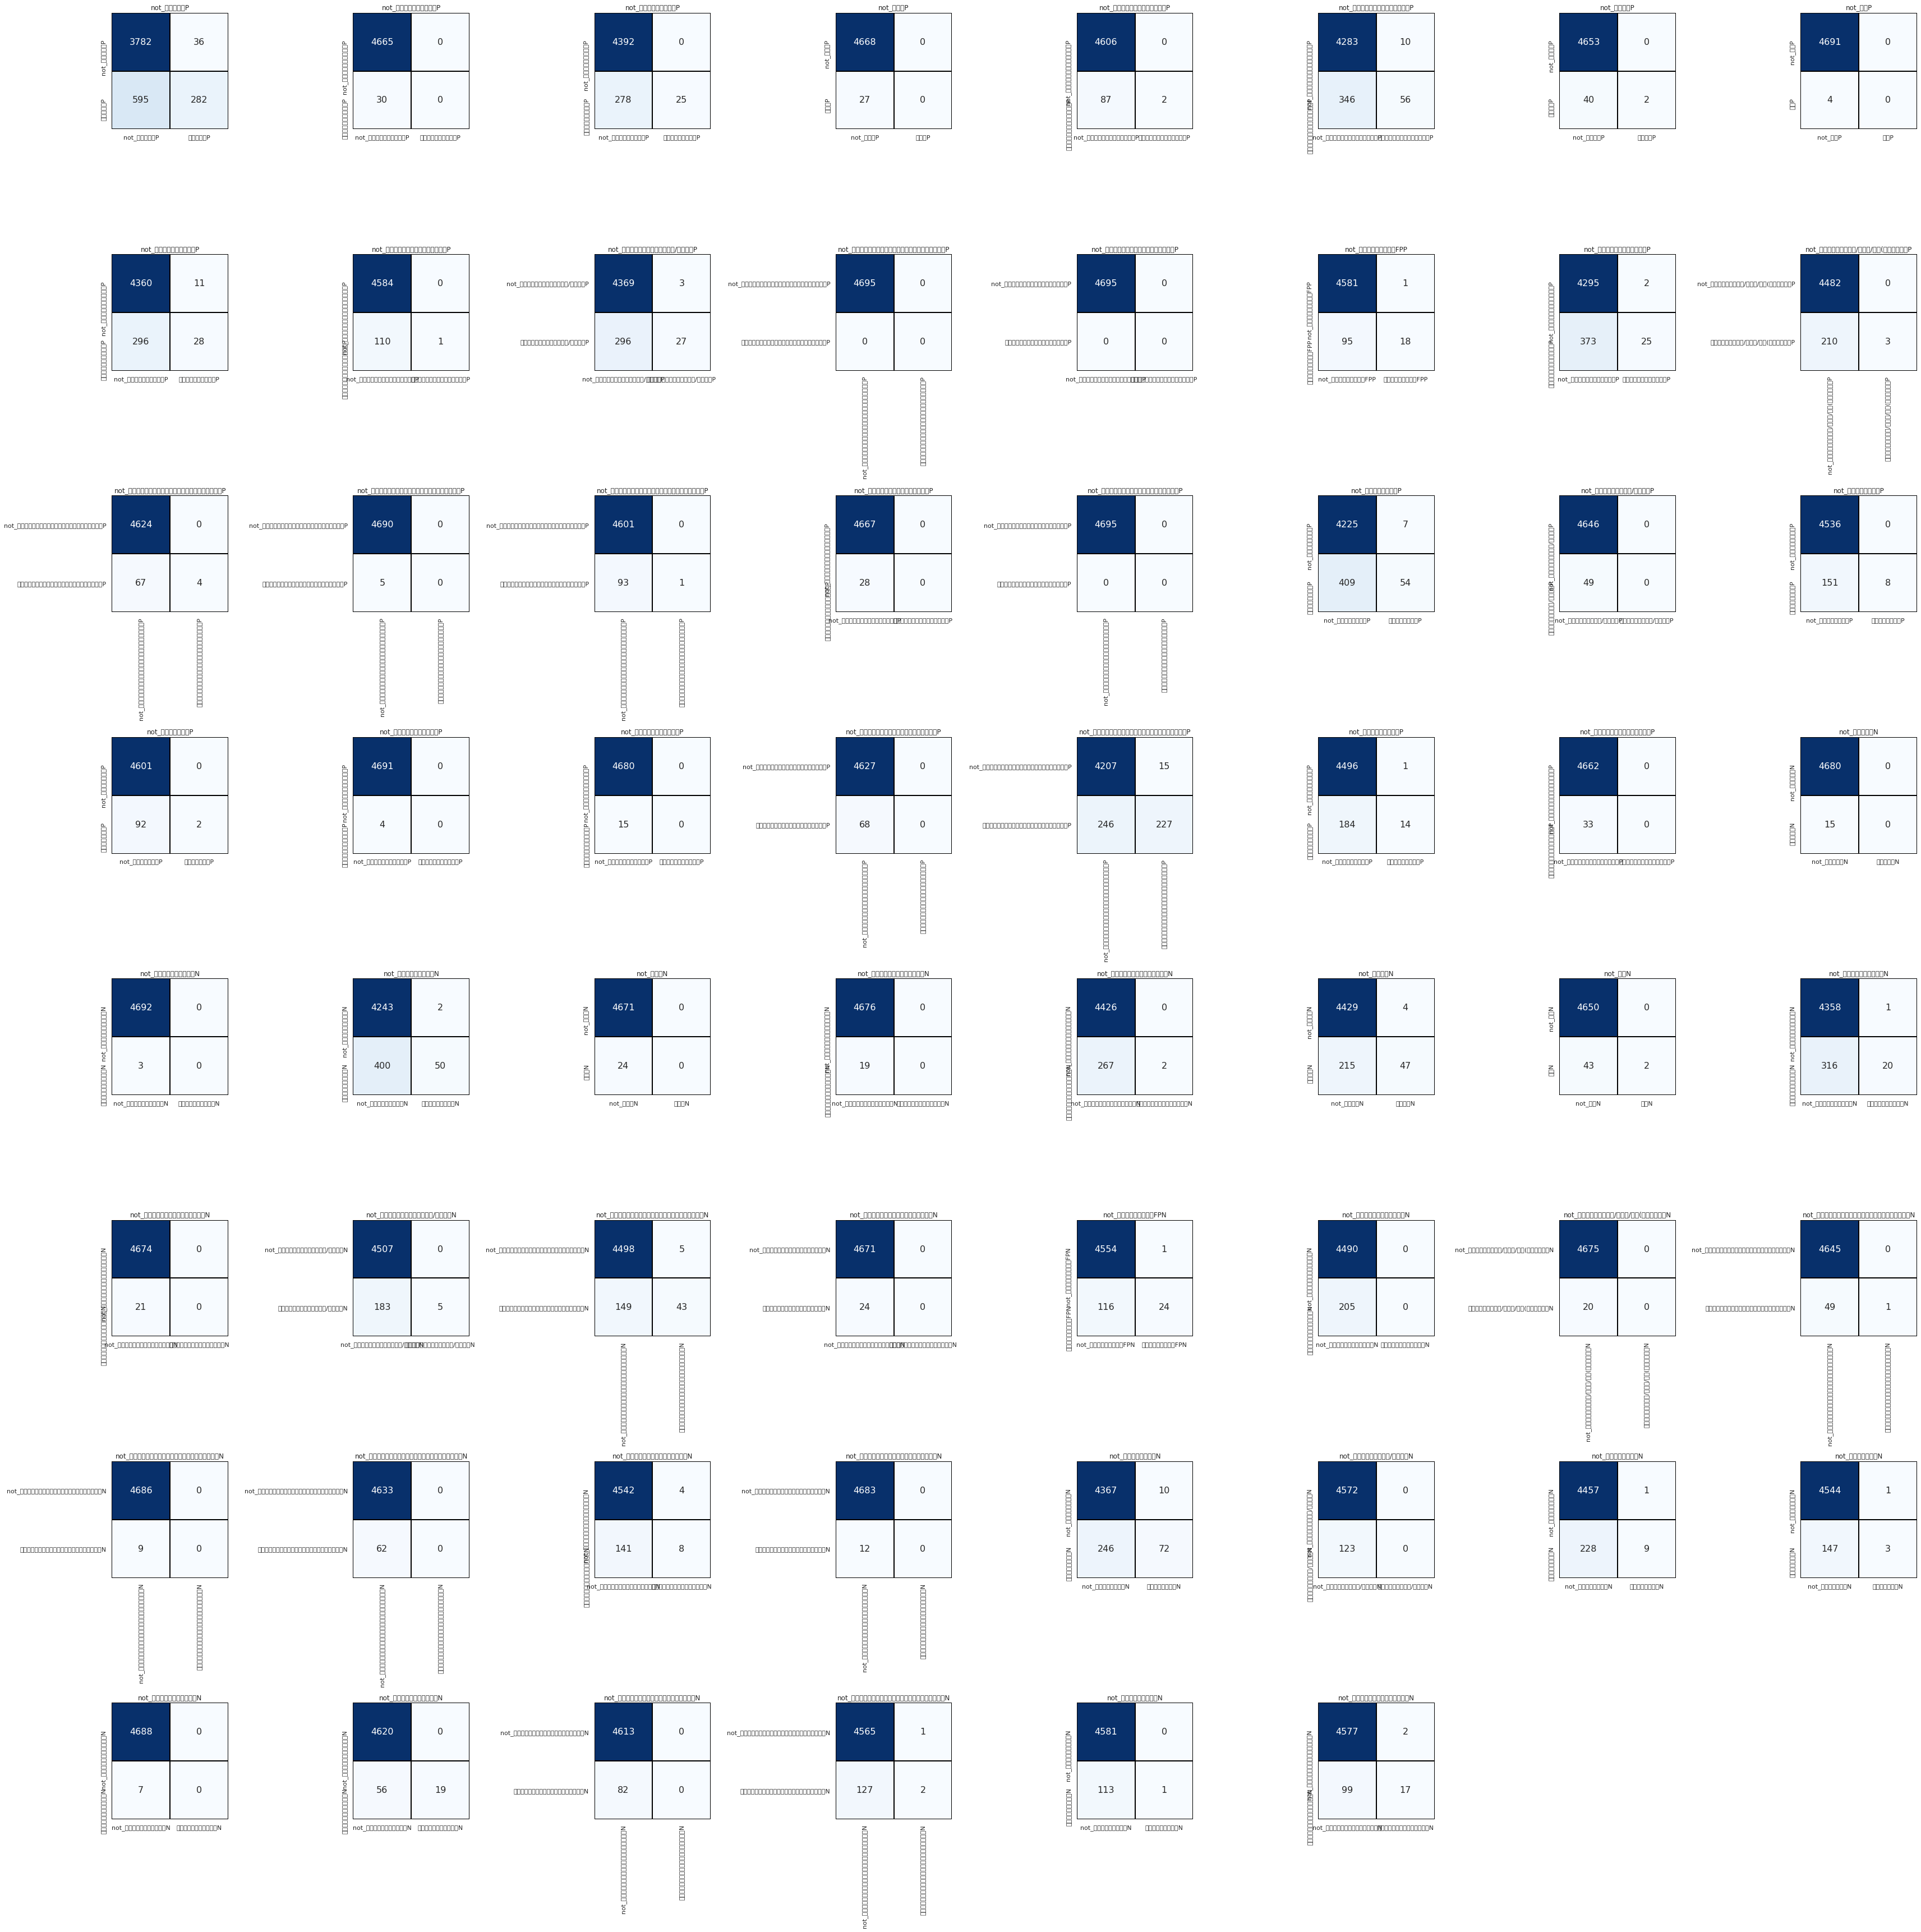

In [103]:
# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(y_test, y_pred)

# Plot confusion matrix 
fig = plt.figure(figsize = (48, 48))  #(42, 24),(90, 40)
for i, (label, matrix) in enumerate(zip(cats_column, confusion)):
    print("(label, matrix):", label, matrix)
    plt.subplot(8,8, i+1)
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, annot_kws={'size':16}, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

In [105]:
# Hmm F-1 score is low, Lets see the distribution of class
Y_test.sum()/len(Y_test)

パーク全般P                      0.186794
園内全体の外観・装飾P                 0.006390
園内全体の混雑状況P                  0.064537
清潔感P                        0.005751
スペシャルイベント（装飾）P              0.018956
                              ...   
【レストルーム】その他N                0.015974
【キャスト】対応能力（迅速さ・正確さ）N        0.017465
【キャスト】態度・印象（笑顔・礼儀・話し方等）N    0.027476
【キャスト】その他N                  0.024281
【その他サービス施設】その他N             0.024707
Length: 62, dtype: float64

Text(0.5, 0, 'Number of messages')

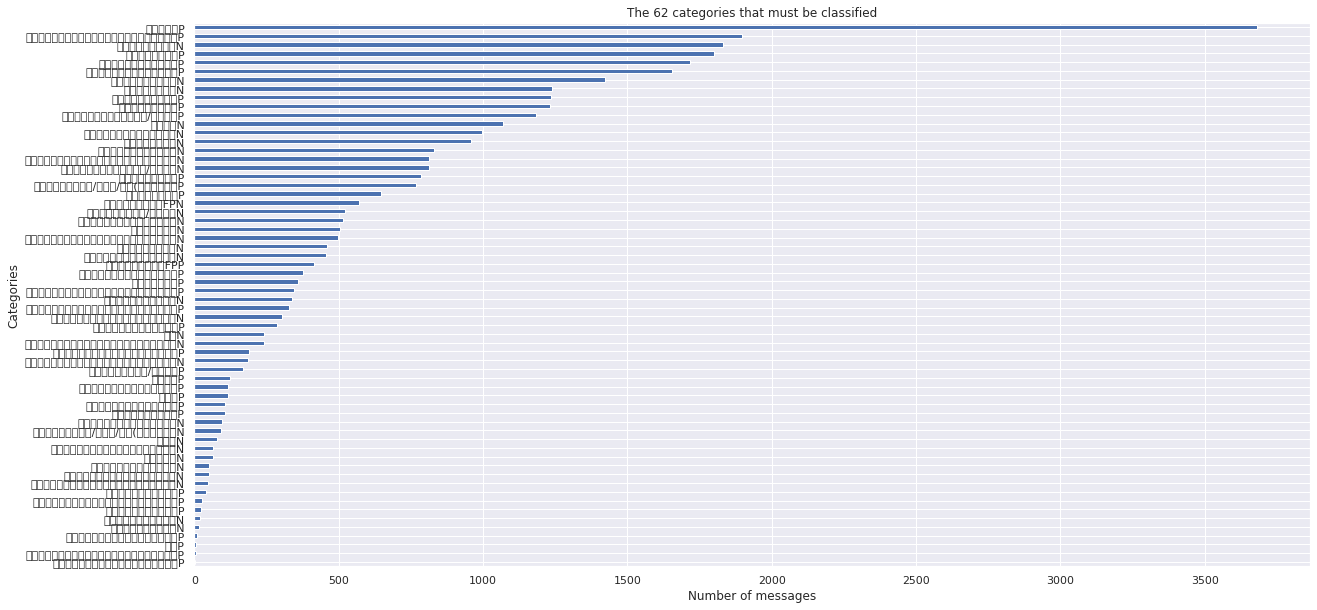

In [107]:
cats=df_train.columns[1:]
plt.figure(figsize=(20,10))
df_train[cats].sum().sort_values().plot.barh()
plt.title('The 62 categories that must be classified')
plt.ylabel('Categories')
plt.xlabel('Number of messages')

In [108]:
df_train[cats].sum().sort_values()

【エンタ】休止・中止（リハブ・シス調）P           1
【アトラクション】休止・工事（リハブ・シス調）P       6
価格P                            7
【アトラクション】休止（天候要因）P             8
園内全体の外観・装飾N                   16
                            ... 
【アトラクション】その他P               1718
【エンタ】その他P                   1800
園内全体の混雑状況N                  1831
【キャスト】態度・印象（笑顔・礼儀・話し方等）P    1896
パーク全般P                      3682
Length: 62, dtype: int64

Text(0.5, 0, 'Number of messages')

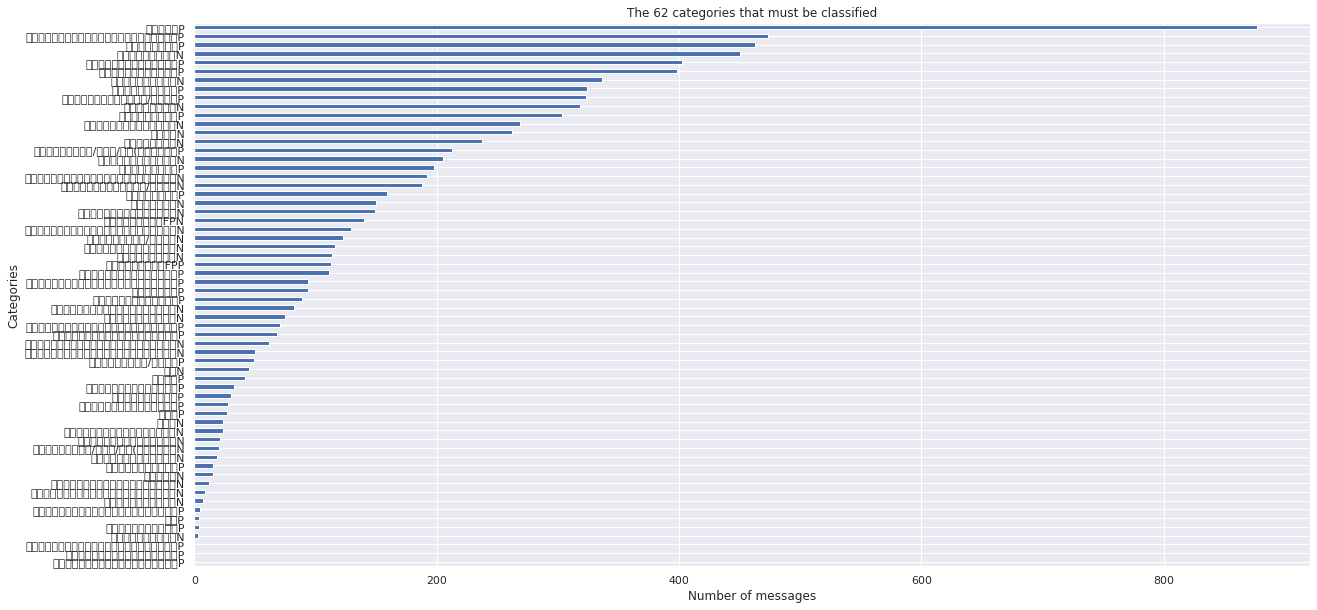

In [109]:
cats=df_test.columns[1:]
plt.figure(figsize=(20,10))
df_test[cats].sum().sort_values().plot.barh()
plt.title('The 62 categories that must be classified')
plt.ylabel('Categories')
plt.xlabel('Number of messages')

In [110]:
df_test[cats].sum().sort_values()

【エンタ】休止・中止（リハブ・シス調）P          0
【アトラクション】休止（天候要因）P            0
【アトラクション】休止・工事（リハブ・シス調）P      0
園内全体の外観・装飾N                   3
【レストルーム】清潔さP                  4
                           ... 
スペシャルイベント（その他）P             402
園内全体の混雑状況N                  450
【エンタ】その他P                   463
【キャスト】態度・印象（笑顔・礼儀・話し方等）P    473
パーク全般P                      877
Length: 62, dtype: int64

# 3.2 XGBClassifier

In [111]:
from xgboost import XGBClassifier

pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer = tokenize))
    , ('tfidf', TfidfTransformer())
    , ('clf', MultiOutputClassifier(XGBClassifier()))])

pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf__estimator__base_score', 'clf__estimator__booster', 'clf__estimator__colsample_bylevel', 'clf__estimator__colsample_bynode', 'clf__estimator__colsample_bytree', 'clf__estimator__gamma', 'clf__estimator__learning_rate', 'clf__estimator__max_delta_step', 'clf__estimator__max_depth', 'clf__estimator__min_child_weight', 'clf__estimator__missing', 'clf__estimator__n_estimators', 'clf__estimator__n_jobs', 'clf__estimator__nthread', 'clf__estimator__objective', 'clf__estimator__random_state', 'clf__estimator__reg_alpha', 'clf__es

In [112]:
params = {'classify__estimator__colsample_bytree': 0.6522,
          'classify__estimator__gamma': 3.6975,
          'classify__estimator__learning_rate': 0.0503,
          'classify__estimator__max_delta_step': 2.0706,
          'classify__estimator__max_depth': 10,
          'classify__estimator__min_child_weight': 31.5800,
          'classify__estimator__n_estimators': 166,
          'classify__estimator__subsample': 0.8639
         }

# _ = pipeline.set_params(**params)

In [113]:
%%time
pipeline.fit(X_train, Y_train)
print("==Score: ",pipeline.score(X_train, Y_train))
Y_pred = pipeline.predict(X_test)
    
# Calculate the accuracy for each of them.
for i in range(len(Y_train.columns)):
    print('Category: {} '.format(Y_train.columns[i]))
    print(classification_report(Y_test.iloc[:, i].values, Y_pred[:, i]))
    print('Accuracy {}\n\n'.format(accuracy_score(Y_test.iloc[:, i].values, Y_pred[:, i])))
    print('F1 {}\n\n'.format(f1_score(Y_test.iloc[:, i].values, Y_pred[:, i],average='weighted')))
    
print("==classification_report: ",classification_report(Y_test.iloc[:, :].values, np.array([x for x in Y_pred]), target_names = Y_train.columns))

y_test,y_pred = Y_test, Y_pred

multi_f1 = multioutput_fscore(y_test,y_pred, beta = 1)
overall_accuracy = (y_pred == y_test).mean().mean()
print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy*100))
print('F1 score (custom definition) {0:.2f}%\n'.format(multi_f1*100))


print("precision_macro:",precision_score(y_test, y_pred, average='macro'))
print("precision_micro:",precision_score(y_test, y_pred, average='micro'))
print("precision_weighted:",precision_score(y_test, y_pred, average='weighted'))

print("recall_macro:",recall_score(y_test, y_pred, average='macro'))
print("recall_micro:",recall_score(y_test, y_pred, average='micro'))
print("recall_weighted:",recall_score(y_test, y_pred, average='weighted'))

print("accuracy:",accuracy_score(y_test, y_pred))
print("accuracy_nonormal:",accuracy_score(y_test, y_pred, normalize=False))

print("hamming_loss:",hamming_loss(y_test, y_pred))

print("hamming_score: ",(y_pred == y_test).mean())
print("avg hamming_score: ",(y_pred == y_test).mean().mean())

# Exact Match ratio:
print("Exact Match ratio: ",(np.all(y_pred == y_test, axis=1).mean()))


==Score:  0.2902177964747857
Category: パーク全般P 
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      3818
           1       0.80      0.38      0.52       877

    accuracy                           0.87      4695
   macro avg       0.84      0.68      0.72      4695
weighted avg       0.86      0.87      0.85      4695

Accuracy 0.8670926517571885


F1 0.8473685409314767


Category: 園内全体の外観・装飾P 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      4665
           1       0.67      0.07      0.12        30

    accuracy                           0.99      4695
   macro avg       0.83      0.53      0.56      4695
weighted avg       0.99      0.99      0.99      4695

Accuracy 0.9938232161874334


F1 0.9913052617614068


Category: 園内全体の混雑状況P 
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4392
           1       0.75      0.41    

In [114]:

cm = multilabel_confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))

[[[3735   83]
  [ 541  336]]

 [[4664    1]
  [  28    2]]

 [[4350   42]
  [ 180  123]]

 [[4666    2]
  [  22    5]]

 [[4595   11]
  [  51   38]]

 [[4262   31]
  [ 298  104]]

 [[4652    1]
  [  42    0]]

 [[4691    0]
  [   4    0]]

 [[4368    3]
  [ 296   28]]

 [[4583    1]
  [ 106    5]]

 [[4338   34]
  [ 138  185]]

 [[4695    0]
  [   0    0]]

 [[4695    0]
  [   0    0]]

 [[4574    8]
  [  45   68]]

 [[4258   39]
  [ 269  129]]

 [[4472   10]
  [ 194   19]]

 [[4616    8]
  [  41   30]]

 [[4690    0]
  [   5    0]]

 [[4591   10]
  [  70   24]]

 [[4664    3]
  [  24    4]]

 [[4695    0]
  [   0    0]]

 [[4177   55]
  [ 285  178]]

 [[4642    4]
  [  42    7]]

 [[4523   13]
  [ 118   41]]

 [[4597    4]
  [  74   20]]

 [[4689    2]
  [   2    2]]

 [[4680    0]
  [  14    1]]

 [[4626    1]
  [  64    4]]

 [[4166   56]
  [ 137  336]]

 [[4472   25]
  [ 130   68]]

 [[4660    2]
  [  24    9]]

 [[4680    0]
  [  15    0]]

 [[4692    0]
  [   3    0]]

 [[4161   

(label, matrix): パーク全般P [[3735   83]
 [ 541  336]]
(label, matrix): 園内全体の外観・装飾P [[4664    1]
 [  28    2]]
(label, matrix): 園内全体の混雑状況P [[4350   42]
 [ 180  123]]
(label, matrix): 清潔感P [[4666    2]
 [  22    5]]
(label, matrix): スペシャルイベント（装飾）P [[4595   11]
 [  51   38]]
(label, matrix): スペシャルイベント（その他）P [[4262   31]
 [ 298  104]]
(label, matrix): 園内環境P [[4652    1]
 [  42    0]]
(label, matrix): 価格P [[4691    0]
 [   4    0]]
(label, matrix): その他（パーク全体）P [[4368    3]
 [ 296   28]]
(label, matrix): 【アトラクション】質（面白さ）P [[4583    1]
 [ 106    5]]
(label, matrix): 【アトラクション】待ち時間/混雑状況P [[4338   34]
 [ 138  185]]
(label, matrix): 【アトラクション】休止・工事（リハブ・シス調）P [[4695    0]
 [   0    0]]
(label, matrix): 【アトラクション】休止（天候要因）P [[4695    0]
 [   0    0]]
(label, matrix): 【アトラクション】FPP [[4574    8]
 [  45   68]]
(label, matrix): 【アトラクション】その他P [[4258   39]
 [ 269  129]]
(label, matrix): 【エンタ】パレード/ショー/花火(質・面白さ）P [[4472   10]
 [ 194   19]]
(label, matrix): 【エンタ】キャラクターグリーティング（出会い）P [[4616    8]
 [  41   30]]
(label

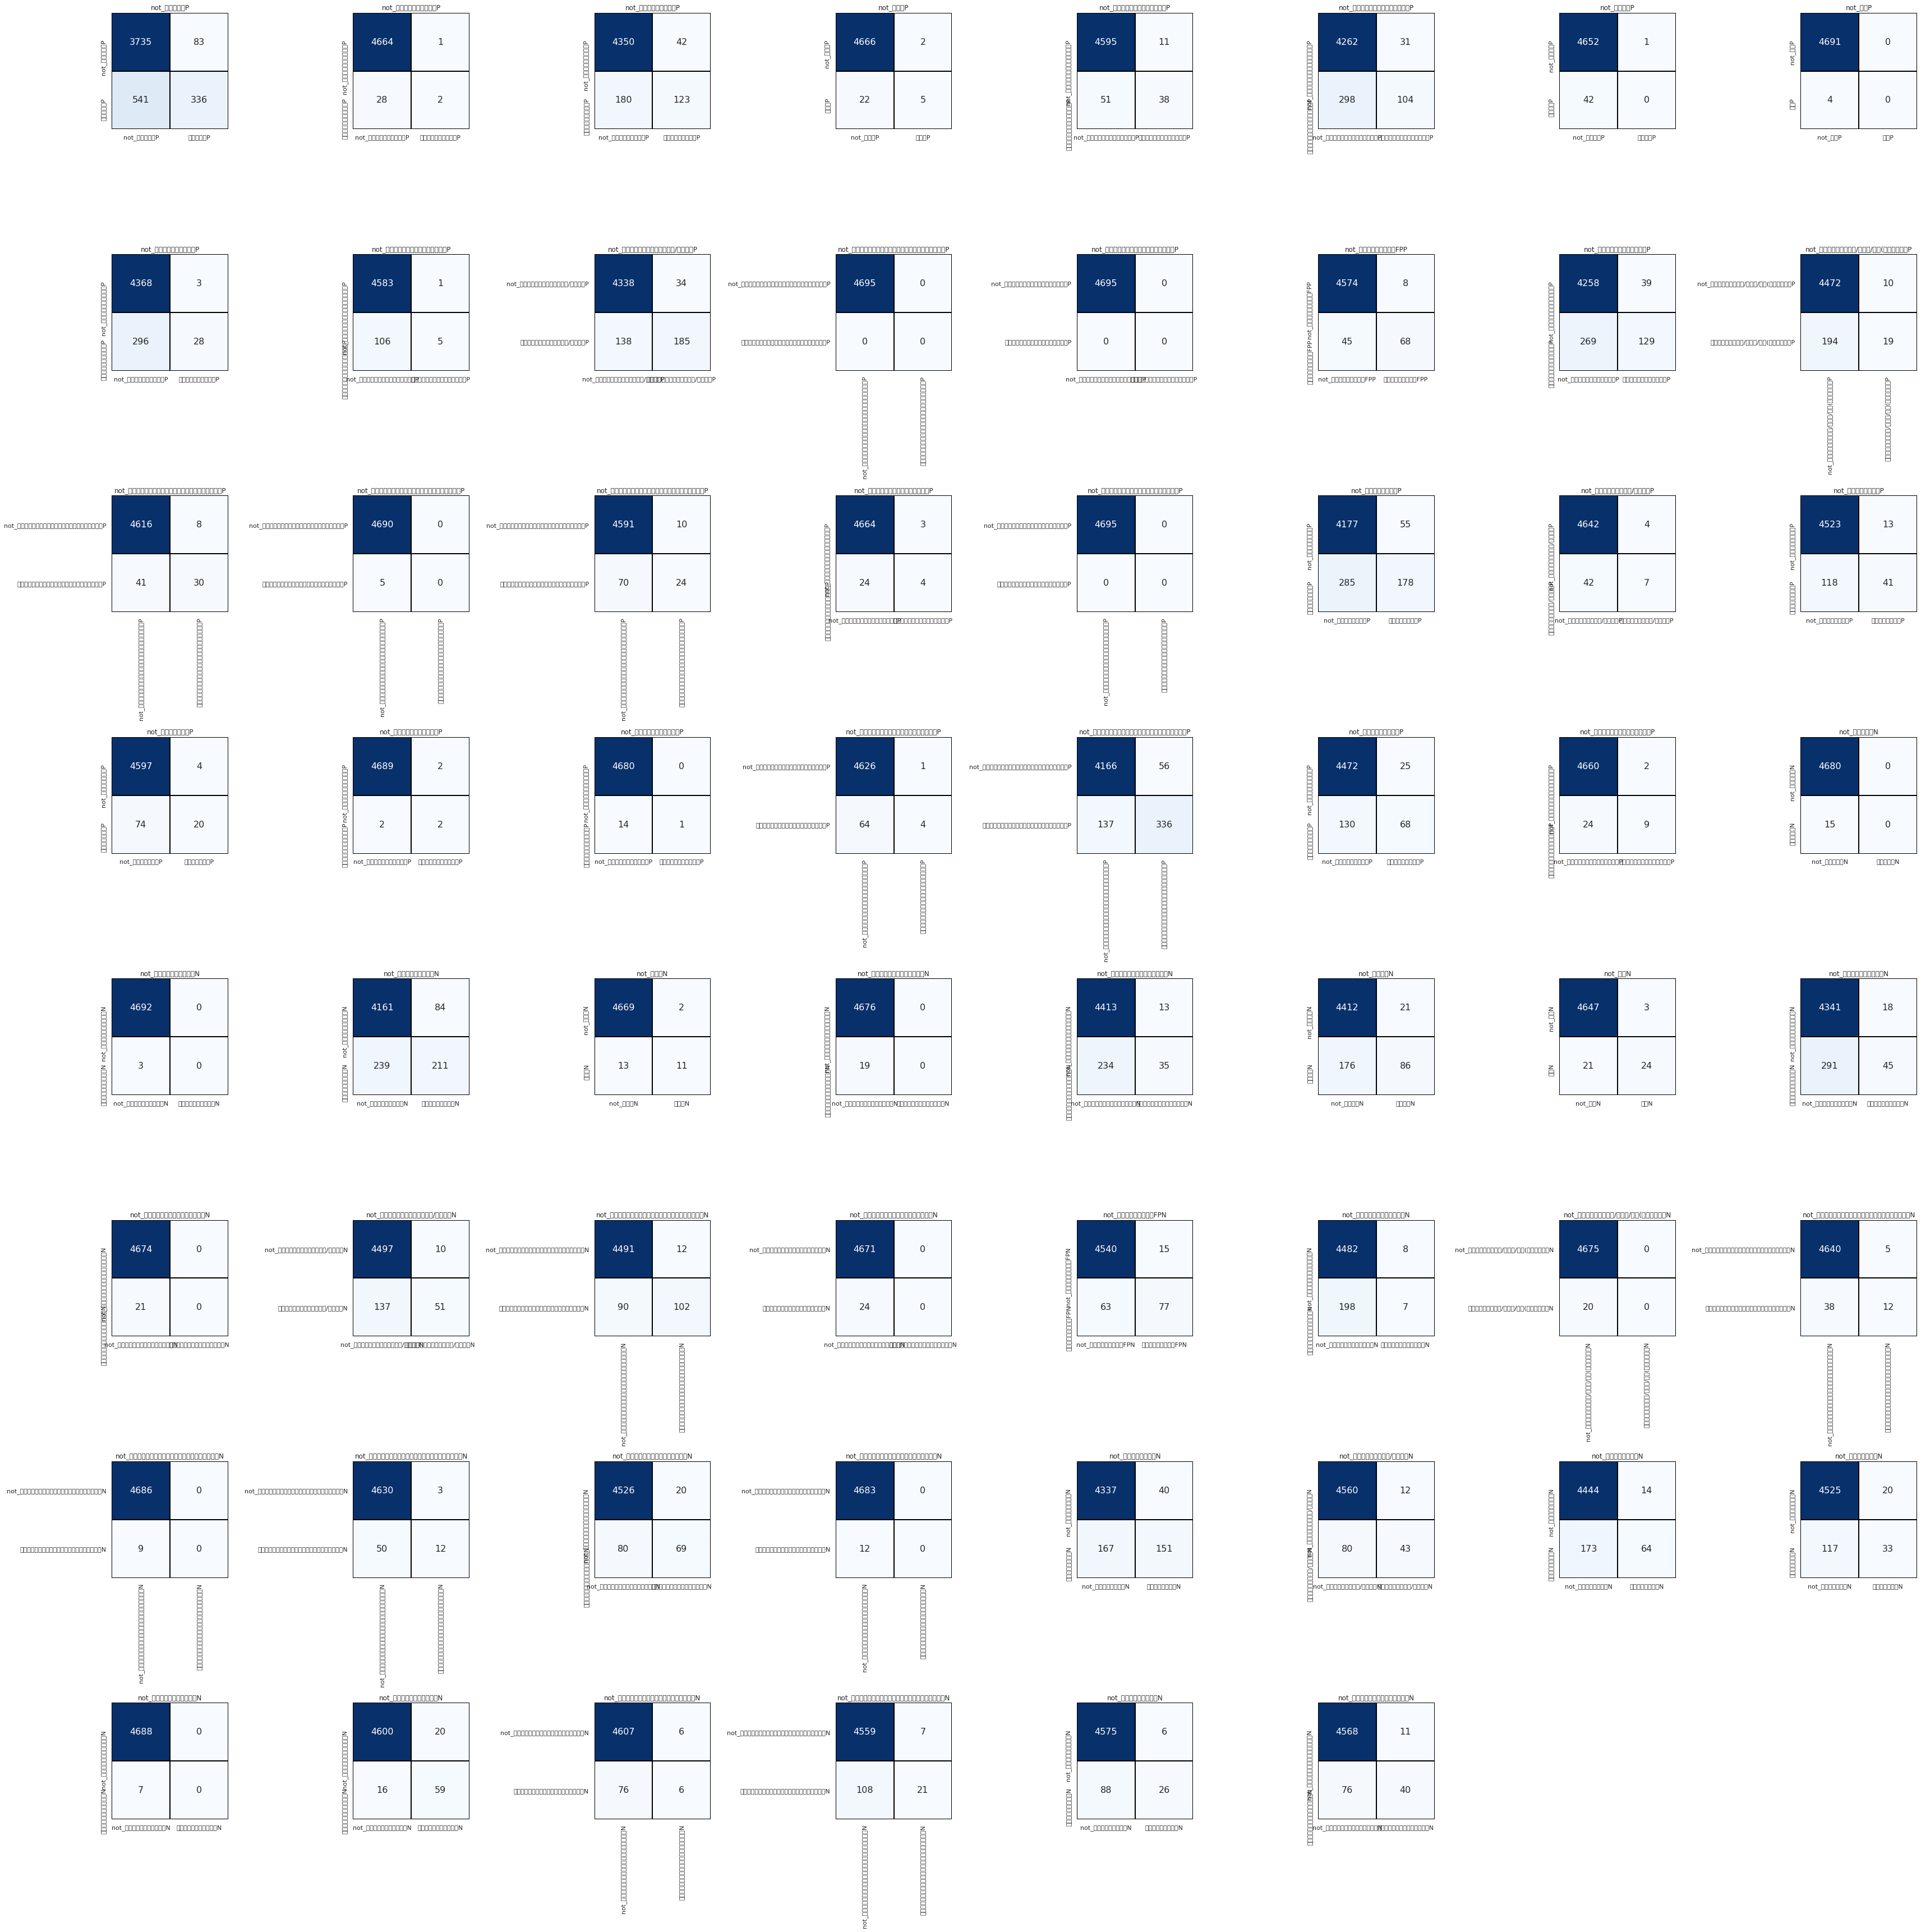

In [115]:
# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(y_test, y_pred)

# Plot confusion matrix 
fig = plt.figure(figsize = (48, 48))  #(42, 24),(90, 40)
for i, (label, matrix) in enumerate(zip(cats_column, confusion)):
    print("(label, matrix):", label, matrix)
    plt.subplot(8,8, i+1)
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, annot_kws={'size':16}, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

# 3.4 AdaBoostClassifier

In [125]:
new_pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
    ))
])

In [126]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [127]:
new_pipeline.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function tokenize at...
                                                                    base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                                          class_weight='balanced',
                                                                                   

In [128]:
Y_pred = new_pipeline.predict(X_test)
    
# Calculate the accuracy for each of them.
for i in range(len(Y_train.columns)):
    print('Category: {} '.format(Y_train.columns[i]))
    print(classification_report(Y_test.iloc[:, i].values, Y_pred[:, i]))
    print('Accuracy {}\n\n'.format(accuracy_score(Y_test.iloc[:, i].values, Y_pred[:, i])))
    print('F1 {}\n\n'.format(f1_score(Y_test.iloc[:, i].values, Y_pred[:, i],average='weighted')))

Category: パーク全般P 
              precision    recall  f1-score   support

           0       0.94      0.85      0.90      3818
           1       0.55      0.78      0.64       877

    accuracy                           0.84      4695
   macro avg       0.75      0.82      0.77      4695
weighted avg       0.87      0.84      0.85      4695

Accuracy 0.8383386581469648


F1 0.8484795589876886


Category: 園内全体の外観・装飾P 
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      4665
           1       0.07      0.40      0.12        30

    accuracy                           0.96      4695
   macro avg       0.53      0.68      0.55      4695
weighted avg       0.99      0.96      0.98      4695

Accuracy 0.9631522896698615


F1 0.9756902542466941


Category: 園内全体の混雑状況P 
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      4392
           1       0.38      0.87      0.53       303

    accurac

In [129]:
print(classification_report(Y_test.iloc[:, :].values, np.array([x[:] for x in Y_pred]), target_names = Y_train.columns))

                          precision    recall  f1-score   support

                  パーク全般P       0.55      0.78      0.64       877
             園内全体の外観・装飾P       0.07      0.40      0.12        30
              園内全体の混雑状況P       0.38      0.87      0.53       303
                    清潔感P       0.27      0.70      0.39        27
          スペシャルイベント（装飾）P       0.41      0.80      0.54        89
         スペシャルイベント（その他）P       0.40      0.78      0.53       402
                   園内環境P       0.05      0.48      0.09        42
                     価格P       0.00      0.00      0.00         4
             その他（パーク全体）P       0.18      0.58      0.27       324
        【アトラクション】質（面白さ）P       0.13      0.70      0.22       111
     【アトラクション】待ち時間/混雑状況P       0.48      0.88      0.62       323
【アトラクション】休止・工事（リハブ・シス調）P       0.00      0.00      0.00         0
      【アトラクション】休止（天候要因）P       0.00      0.00      0.00         0
            【アトラクション】FPP       0.43      0.96      0.59       113
         

In [130]:
y_test,y_pred = Y_test.values, Y_pred

multi_f1 = multioutput_fscore(y_test,y_pred, beta = 1)
overall_accuracy = (y_pred == y_test).mean().mean()
print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy*100))
print('F1 score (custom definition) {0:.2f}%\n'.format(multi_f1*100))

Average overall accuracy 94.08% 

F1 score (custom definition) 95.19%



In [131]:
print("==classification_report: ",classification_report(Y_test.iloc[:, :].values, np.array([x for x in Y_pred]), target_names = Y_train.columns))

y_test,y_pred = Y_test, Y_pred

multi_f1 = multioutput_fscore(y_test,y_pred, beta = 1)
overall_accuracy = (y_pred == y_test).mean().mean()
print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy*100))
print('F1 score (custom definition) {0:.2f}%\n'.format(multi_f1*100))


print("precision_macro:",precision_score(y_test, y_pred, average='macro'))
print("precision_micro:",precision_score(y_test, y_pred, average='micro'))
print("precision_weighted:",precision_score(y_test, y_pred, average='weighted'))

print("recall_macro:",recall_score(y_test, y_pred, average='macro'))
print("recall_micro:",recall_score(y_test, y_pred, average='micro'))
print("recall_weighted:",recall_score(y_test, y_pred, average='weighted'))

print("accuracy:",accuracy_score(y_test, y_pred))
print("accuracy_nonormal:",accuracy_score(y_test, y_pred, normalize=False))

print("hamming_loss:",hamming_loss(y_test, y_pred))

print("hamming_score: ",(y_pred == y_test).mean())
print("avg hamming_score: ",(y_pred == y_test).mean().mean())

# Exact Match ratio:
print("Exact Match ratio: ",(np.all(y_pred == y_test, axis=1).mean()))

==classification_report:                            precision    recall  f1-score   support

                  パーク全般P       0.55      0.78      0.64       877
             園内全体の外観・装飾P       0.07      0.40      0.12        30
              園内全体の混雑状況P       0.38      0.87      0.53       303
                    清潔感P       0.27      0.70      0.39        27
          スペシャルイベント（装飾）P       0.41      0.80      0.54        89
         スペシャルイベント（その他）P       0.40      0.78      0.53       402
                   園内環境P       0.05      0.48      0.09        42
                     価格P       0.00      0.00      0.00         4
             その他（パーク全体）P       0.18      0.58      0.27       324
        【アトラクション】質（面白さ）P       0.13      0.70      0.22       111
     【アトラクション】待ち時間/混雑状況P       0.48      0.88      0.62       323
【アトラクション】休止・工事（リハブ・シス調）P       0.00      0.00      0.00         0
      【アトラクション】休止（天候要因）P       0.00      0.00      0.00         0
            【アトラクション】FPP       0.43      0.96    

In [132]:
cm = multilabel_confusion_matrix(y_test, y_pred)
print(cm)
print(classification_report(y_test,y_pred))


[[[3249  569]
  [ 190  687]]

 [[4510  155]
  [  18   12]]

 [[3967  425]
  [  40  263]]

 [[4617   51]
  [   8   19]]

 [[4504  102]
  [  18   71]]

 [[3828  465]
  [  88  314]]

 [[4290  363]
  [  22   20]]

 [[4690    1]
  [   4    0]]

 [[3502  869]
  [ 135  189]]

 [[4076  508]
  [  33   78]]

 [[4060  312]
  [  39  284]]

 [[4694    1]
  [   0    0]]

 [[4691    4]
  [   0    0]]

 [[4436  146]
  [   4  109]]

 [[3795  502]
  [  79  319]]

 [[4004  478]
  [  61  152]]

 [[4493  131]
  [   7   64]]

 [[4647   43]
  [   4    1]]

 [[4400  201]
  [  27   67]]

 [[4556  111]
  [   9   19]]

 [[4695    0]
  [   0    0]]

 [[3733  499]
  [  74  389]]

 [[4488  158]
  [  13   36]]

 [[4280  256]
  [  27  132]]

 [[4368  233]
  [  22   72]]

 [[4681   10]
  [   4    0]]

 [[4667   13]
  [   9    6]]

 [[4385  242]
  [  22   46]]

 [[3986  236]
  [  50  423]]

 [[4097  400]
  [  29  169]]

 [[4582   80]
  [  12   21]]

 [[4501  179]
  [   9    6]]

 [[4680   12]
  [   2    1]]

 [[3838  4

(label, matrix): パーク全般P [[3249  569]
 [ 190  687]]
(label, matrix): 園内全体の外観・装飾P [[4510  155]
 [  18   12]]
(label, matrix): 園内全体の混雑状況P [[3967  425]
 [  40  263]]
(label, matrix): 清潔感P [[4617   51]
 [   8   19]]
(label, matrix): スペシャルイベント（装飾）P [[4504  102]
 [  18   71]]
(label, matrix): スペシャルイベント（その他）P [[3828  465]
 [  88  314]]
(label, matrix): 園内環境P [[4290  363]
 [  22   20]]
(label, matrix): 価格P [[4690    1]
 [   4    0]]
(label, matrix): その他（パーク全体）P [[3502  869]
 [ 135  189]]
(label, matrix): 【アトラクション】質（面白さ）P [[4076  508]
 [  33   78]]
(label, matrix): 【アトラクション】待ち時間/混雑状況P [[4060  312]
 [  39  284]]
(label, matrix): 【アトラクション】休止・工事（リハブ・シス調）P [[4694    1]
 [   0    0]]
(label, matrix): 【アトラクション】休止（天候要因）P [[4691    4]
 [   0    0]]
(label, matrix): 【アトラクション】FPP [[4436  146]
 [   4  109]]
(label, matrix): 【アトラクション】その他P [[3795  502]
 [  79  319]]
(label, matrix): 【エンタ】パレード/ショー/花火(質・面白さ）P [[4004  478]
 [  61  152]]
(label, matrix): 【エンタ】キャラクターグリーティング（出会い）P [[4493  131]
 [   7   64]]
(label

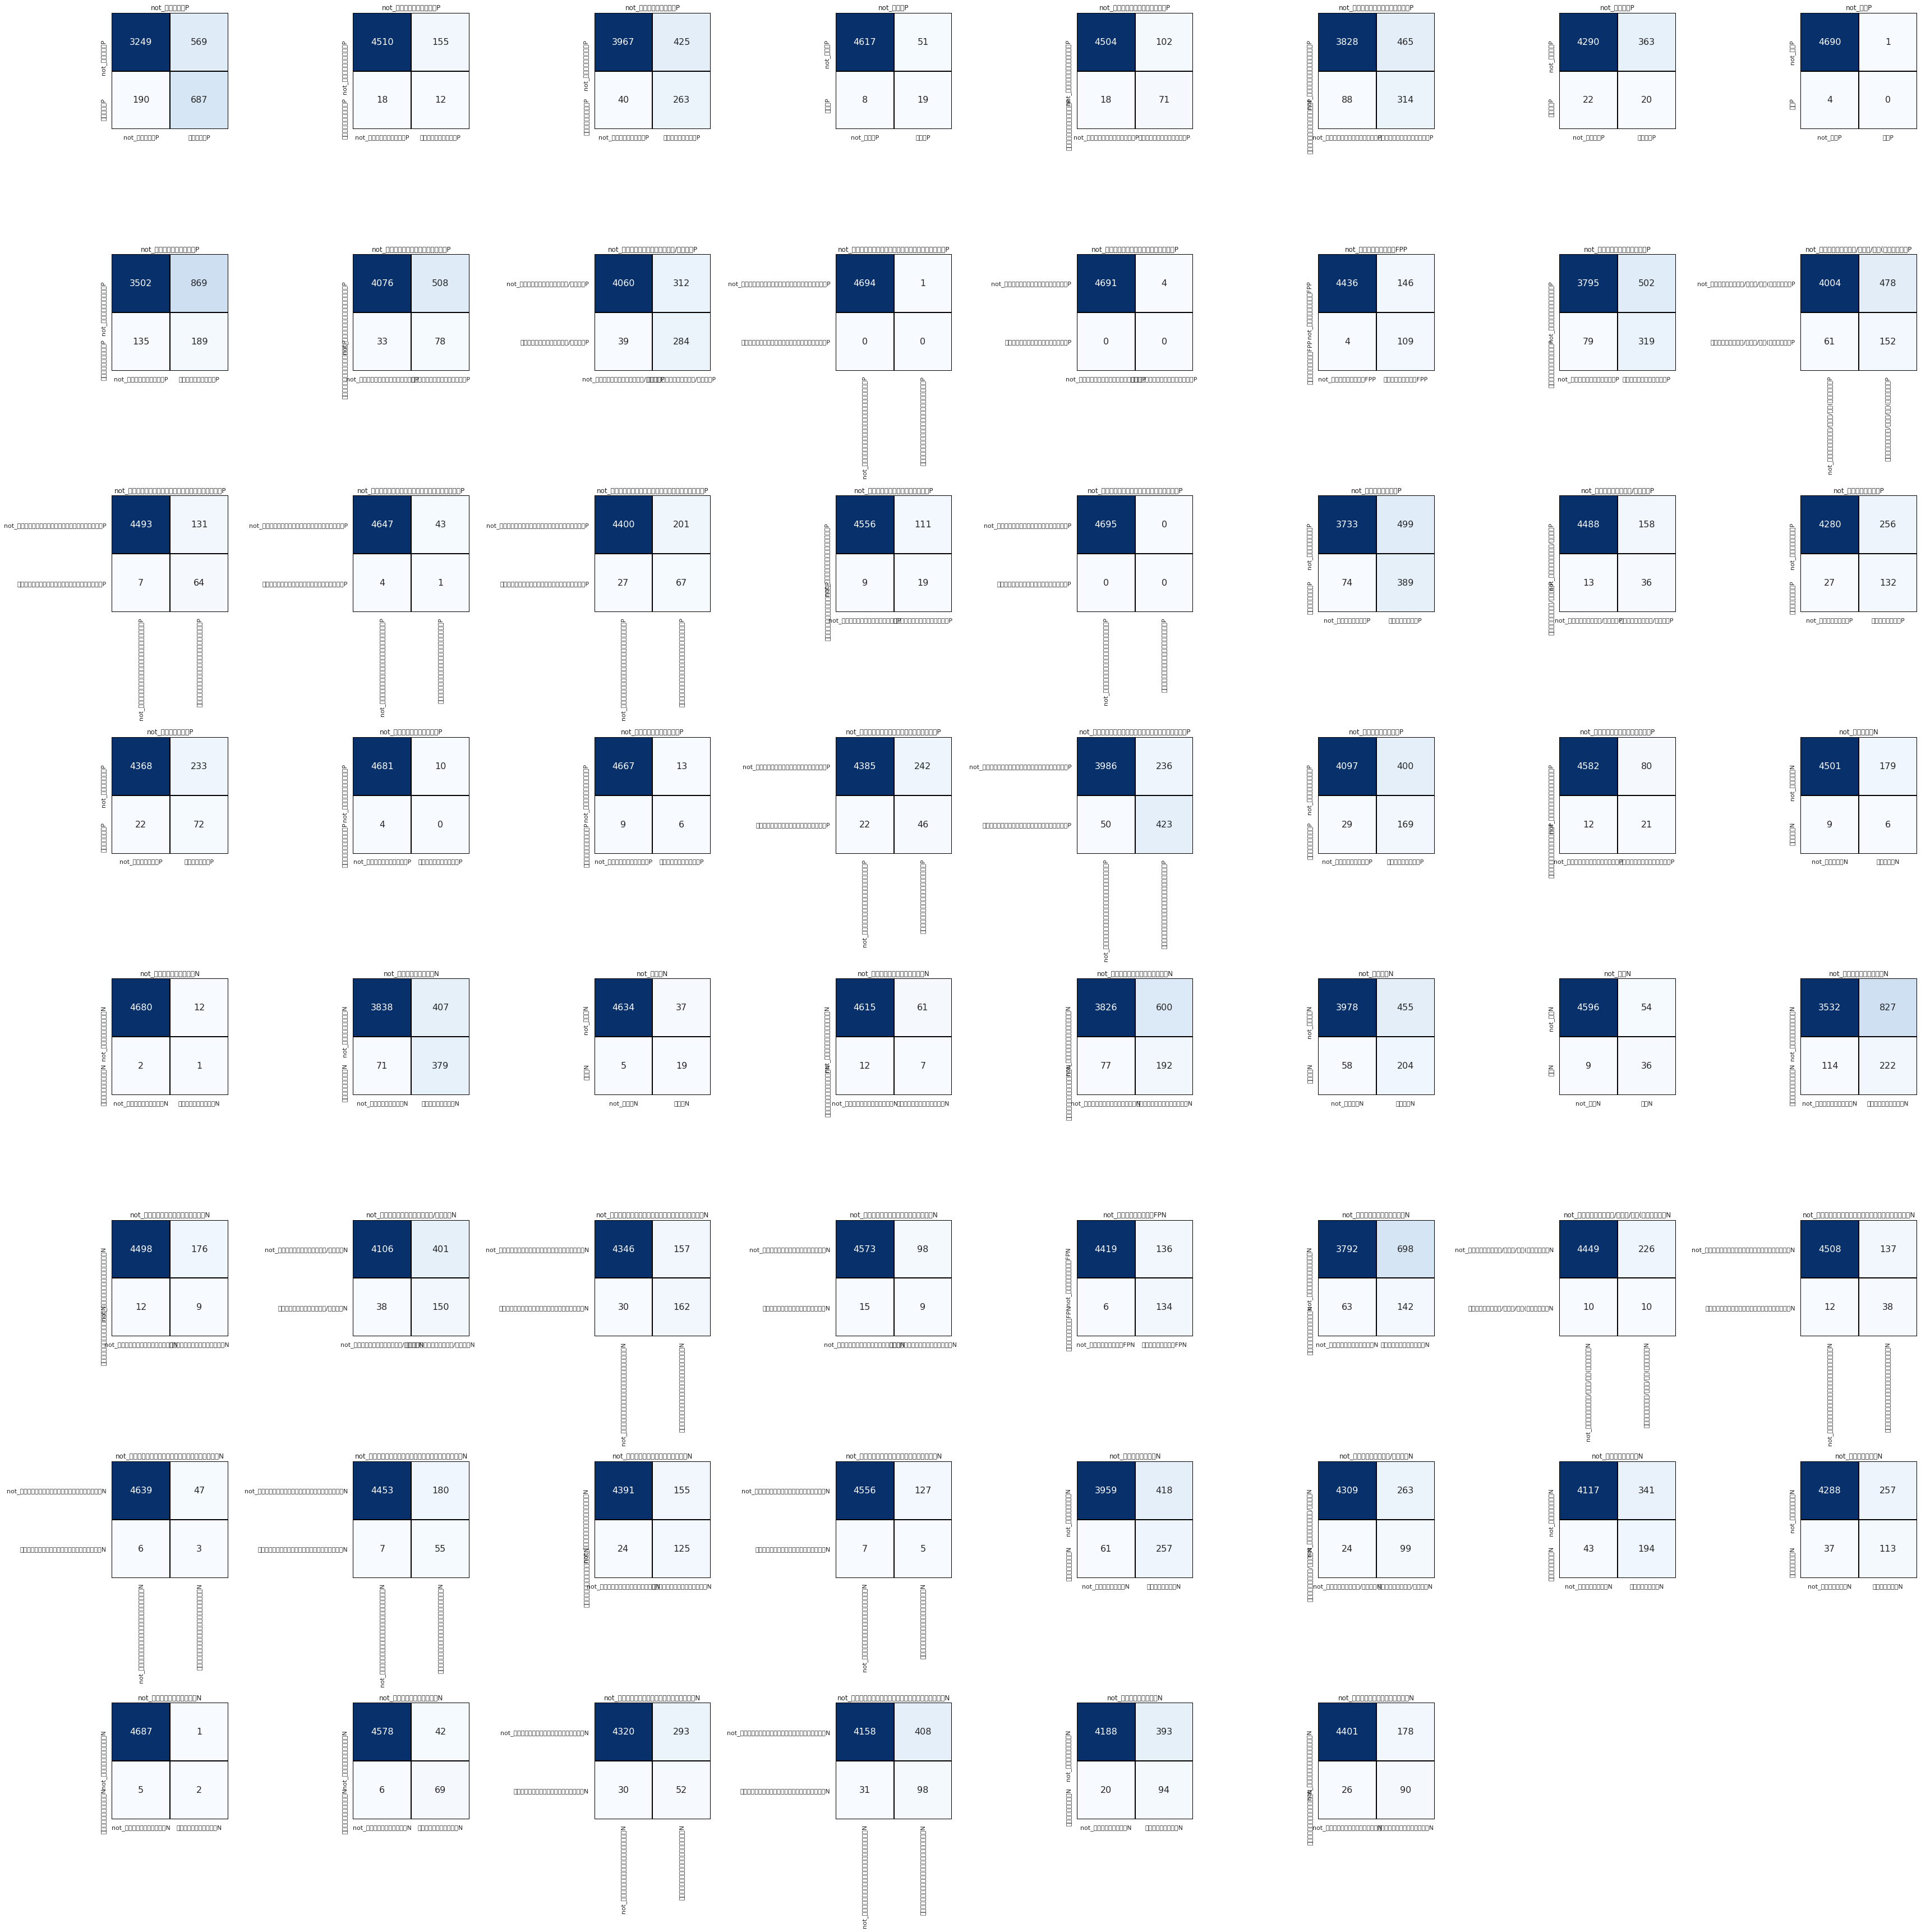

In [133]:
# Creating multilabel confusion matrix
confusion = multilabel_confusion_matrix(y_test, y_pred)

# Plot confusion matrix 
fig = plt.figure(figsize = (48, 48))  #(42, 24),(90, 40)
for i, (label, matrix) in enumerate(zip(cats_column, confusion)):
    print("(label, matrix):", label, matrix)
    plt.subplot(8,8, i+1)
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot = True, annot_kws={'size':16}, square = True, fmt = 'd', cbar = False, cmap = 'Blues', 
                xticklabels = labels, yticklabels = labels, linecolor = 'black', linewidth = 1)
    plt.title(labels[0])

plt.tight_layout()
plt.show()

# 6. Improve the model
Use grid search to find better parameters.

In [ ]:
%%time
#grid search
parameters = {'vect__min_df': [1, 5],
              'tfidf__use_idf':[True, False],
              'clf__estimator__n_estimators':[10, 25], 
              'clf__estimator__min_samples_split':[2, 5, 10]}

pipeline_cv = GridSearchCV(estimator=pipeline, param_grid=parameters, verbose=3)

In [134]:
# hyperparameter optimization
pipeline_ada = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(
        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced'))
    ))
])

parameters_ada = {
    'clf__estimator__learning_rate': [0.1, 0.3],
    'clf__estimator__n_estimators': [100, 200]
}

cv_ada = GridSearchCV(estimator=pipeline_ada, param_grid=parameters_ada, cv=3, scoring='f1_weighted', verbose=3)

In [ ]:
%%time
cv_ada.fit(X_train, Y_train)

In [ ]:
print('Best Parameters:', cv_ada.best_params_)

In [ ]:
Y_pred = cv_ada.predict(X_test)
    
print(classification_report(Y_test.iloc[:, :].values, np.array([x[:] for x in Y_pred]), target_names = Y_train.columns))

In [ ]:
y_test,y_pred = Y_test.values, Y_pred

multi_f1 = multioutput_fscore(y_test,y_pred, beta = 1)
overall_accuracy = (y_pred == y_test).mean().mean()
print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy*100))
print('F1 score (custom definition) {0:.2f}%\n'.format(multi_f1*100))

# 7. Test the model
Show the accuracy, precision, and recall of the tuned model.

In [ ]:
%%time
pipeline_cv.fit(X_train, Y_train)
print('===Best Parameters:', pipeline_cv.best_params_)

pickle.dump(pipeline_cv, open('./disney_rf_model.sav', 'wb'))


In [ ]:
loaded_model = pickle.load(open('./disney_rf_model.sav', 'rb'))
Y_pred = loaded_model.predict(X_test)
    
print(classification_report(Y_test.iloc[:, :].values, np.array([x[:] for x in Y_pred]), target_names = Y_train.columns))


In [138]:
def multioutput_fscore(y_true,y_pred,beta=1):
    score_list = []
    if isinstance(y_pred, pd.DataFrame) == True:
        y_pred = y_pred.values
    if isinstance(y_true, pd.DataFrame) == True:
        y_true = y_true.values
    for column in range(0,y_true.shape[1]):
        score = fbeta_score(y_true[:,column],y_pred[:,column],beta,average='weighted')
        score_list.append(score)
    f1score_numpy = np.asarray(score_list)
    f1score_numpy = f1score_numpy[f1score_numpy<1]
    f1score = gmean(f1score_numpy)
    return  f1score


In [139]:
y_test,y_pred = Y_test.values, Y_pred

multi_f1 = multioutput_fscore(y_test,y_pred, beta = 1)
overall_accuracy = (y_pred == y_test).mean().mean()
print('Average overall accuracy {0:.2f}% \n'.format(overall_accuracy*100))
print('F1 score (custom definition) {0:.2f}%\n'.format(multi_f1*100))

Average overall accuracy 94.08% 

F1 score (custom definition) 95.19%



# 8. Try improving model further. 
try other machine learning algorithms
add other features besides the TF-IDF

In [140]:
from sklearn.base import BaseEstimator, TransformerMixin
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            first_word, first_tag = pos_tags[0]
            if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                return True
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

# 9. Export final model as a pickle file

In [ ]:
pickle.dump(cv_ada, open('./disney_ada_model.sav', 'wb'))

# 10. Wrapping into main function

In [ ]:
def main():
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    # build pipeline
    pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(RandomForestClassifier()))      
    ])     
        
    # train classifier
    pipeline.fit(X_train, y_train)
    # predict on test data
    y_pred=pipeline.predict(X_test)
    # display results
    #display_results(y_test, y_pred)


# Others. Selection of other models

To assess the quality and compare models will use cross-validation for 5 folds.

In [141]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [142]:
# AdaBoostClassifier  --OK
clf_ab = MultiOutputClassifier(AdaBoostClassifier(n_estimators=100, random_state=0)).fit(features_train, y_train)
y_pred_ab = clf_ab.predict(features_test)
score = f1_score(y_test, y_pred_ab, average='macro')
print('F1-score of {}: {}'.format(clf_ab, score))
print(classification_report(y_test, y_pred_ab))

F1-score of MultiOutputClassifier(estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                   base_estimator=None,
                                                   learning_rate=1.0,
                                                   n_estimators=100,
                                                   random_state=0),
                      n_jobs=None): 0.03712554778912551
              precision    recall  f1-score   support

           0       0.61      0.14      0.23       877
           1       0.00      0.00      0.00        30
           2       0.55      0.07      0.12       303
           3       0.00      0.00      0.00        27
           4       0.50      0.01      0.02        89
           5       0.17      0.02      0.04       402
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00         4
           8       0.16      0.01      0.02       324
           9       0.25      0.01      0

In [ ]:
# DecisionTreeClassifier(random_state=0) --OK
clf_dt = MultiOutputClassifier(DecisionTreeClassifier(random_state=0)).fit(features_train, y_train)
y_pred_dt = clf_dt.predict(features_test)
score = f1_score(y_test, y_pred_dt, average='macro')
print('F1-score of {}: {}'.format(clf_dt, score))
print(classification_report(y_test, y_pred_dt))

In [ ]:
# MultinomialNB(0.005)  --OK
clf_mnb = MultiOutputClassifier(MultinomialNB(0.005)).fit(features_train, y_train)
y_pred_mnb = clf_mnb.predict(features_test)
score = f1_score(y_test, y_pred_mnb, average='macro')
print('F1-score of {}: {}'.format(clf_mnb, score))
print(classification_report(y_test, y_pred_mnb))

In [ ]:
# XGBClassifier(tree_method='gpu_hist')
clf_xgb = MultiOutputClassifier(XGBClassifier()).fit(features_train, y_train)
y_pred_xgb = clf_xgb.predict(features_test)
score = f1_score(y_test, y_pred_xgb, average='macro')
print('F1-score of {}: {}'.format(clf_xgb, score))
print(classification_report(y_test, y_pred_xgb))